<a href="https://colab.research.google.com/github/gbadeleye/Manufacturing-Projects/blob/main/Multistage_Continuous_Flow_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
 # Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from IPython.display import display
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.stattools import pacf
import statsmodels.api as sm
!pip install gekko
from gekko import GEKKO
path = '/content/drive/MyDrive/Kaggle/General Forked Projects & Notebooks/Multi-stage continuous-flow manufacturing process.zip (Unzipped Files)/'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
# Load Dataset, parse "time-stamp" column as 1-sec time variable and set as index
df = pd.read_csv('/content/drive/MyDrive/Kaggle/General Forked Projects & Notebooks/Multi-stage continuous-flow manufacturing process.zip (Unzipped Files)/continuous_factory_process.csv',
                 parse_dates=['time_stamp']).set_index('time_stamp').to_period('1S')
test2=df.index
df.index=df.index.to_timestamp()
df.head()

AmbientConditions.AmbientHumidity.U.Actual  \
time_stamp                                                        
2019-03-06 10:52:33                                       17.24   
2019-03-06 10:52:34                                       17.24   
2019-03-06 10:52:35                                       17.24   
2019-03-06 10:52:36                                       17.24   
2019-03-06 10:52:37                                       17.24   

                     AmbientConditions.AmbientTemperature.U.Actual  \
time_stamp                                                           
2019-03-06 10:52:33                                          23.53   
2019-03-06 10:52:34                                          23.53   
2019-03-06 10:52:35                                          23.53   
2019-03-06 10:52:36                                          23.53   
2019-03-06 10:52:37                                          23.53   

                     Machine1.RawMaterial.Property1  \
time_stamp                                            
2019-03-06 10:52:33                           11.54   
2019-03-06 10:52:34                           11.54   
2019-03-06 10:52:35                           11.54   
2019-03-06 10:52:36                           11.54   
2019-03-06 10:52:37                           11.54   

                     Machine1.RawMaterial.Property2  \
time_stamp                                            
2019-03-06 10:52:33                             200   
2019-03-06 10:52:34                             200   
2019-03-06 10:52:35                             200   
2019-03-06 10:52:36                             200   
2019-03-06 10:52:37                             200   

                     Machine1.RawMaterial.Property3  \
time_stamp                                            
2019-03-06 10:52:33                           963.0   
2019-03-06 10:52:34                           963.0   
2019-03-06 10:52:35                           963.0   
2019-03-06 10:52:36                           963.0   
2019-03-06 10:52:37                           963.0   

                     Machine1.RawMaterial.Property4  \
time_stamp                                            
2019-03-06 10:52:33                             247   
2019-03-06 10:52:34                             247   
2019-03-06 10:52:35                             247   
2019-03-06 10:52:36                             247   
2019-03-06 10:52:37                             247   

                     Machine1.RawMaterialFeederParameter.U.Actual  \
time_stamp                                                          
2019-03-06 10:52:33                                       1241.26   
2019-03-06 10:52:34                                       1246.09   
2019-03-06 10:52:35                                       1246.29   
2019-03-06 10:52:36                                       1247.59   
2019-03-06 10:52:37                                       1252.83   

                     Machine1.Zone1Temperature.C.Actual  \
time_stamp                                                
2019-03-06 10:52:33                                72.0   
2019-03-06 10:52:34                                72.0   
2019-03-06 10:52:35                                72.0   
2019-03-06 10:52:36                                72.0   
2019-03-06 10:52:37                                72.1   

                     Machine1.Zone2Temperature.C.Actual  \
time_stamp                                                
2019-03-06 10:52:33                                72.3   
2019-03-06 10:52:34                                72.3   
2019-03-06 10:52:35                                72.3   
2019-03-06 10:52:36                                72.3   
2019-03-06 10:52:37                                72.4   

                     Machine1.MotorAmperage.U.Actual  ...  \
time_stamp                                            ...   
2019-03-06 10:52:33                            48.03  ...   
2019-03-06 10:52:34  

Before continuing, need to check the timestamps in the dataframe index, to confirm that they're sequential, i.e. there are no missing timestamps and/or instances of multiple entries of existing timestamps.

In [43]:
# Function to check sequentiality of dataframe timestamps
def check_df_index():
  # First create list of sequential timestamps, whose start/end timestamps coincide with those of the dataframe index and follow the same
  # 1-sec frequency
  range1=pd.date_range(start=df.index[0],end=df.index[-1],freq=pd.DateOffset(seconds=1))
  
  # Copy timestamps of dataframe index
  range2=df.index
  
  # Perform Analyses
  print(f"The following timestamps are not in the dataframe index:\n{[str(x) for x in range1.difference(range2).to_list()]}")
  print(f"\nThe lengths of the dataframe index and the reconstructed sequential index are:\ndf index: {len(range2)}\nsequential index: {len(range1)}")
  counts={}
  names=[str(x) for x in range2.to_list()]
  for name in names:
    counts[name]=counts.get(name,0)+1
  print(f"\nThe timestamps appearing multiple times in the dataframe index including their counts are:\n{[(x,counts[x]) for x in counts.keys() if counts[x]>1]}")

check_df_index()

The following timestamps are not in the dataframe index:
['2019-03-06 11:07:52', '2019-03-06 11:26:16', '2019-03-06 12:27:39', '2019-03-06 12:32:59', '2019-03-06 12:40:52', '2019-03-06 13:15:39', '2019-03-06 13:23:06', '2019-03-06 13:31:48', '2019-03-06 13:37:15', '2019-03-06 13:46:22', '2019-03-06 13:51:46', '2019-03-06 13:56:30', '2019-03-06 14:04:14', '2019-03-06 14:25:03']

The lengths of the dataframe index and the reconstructed sequential index are:
df index: 14088
sequential index: 14088

The timestamps appearing multiple times in the dataframe index including their counts are:
[('2019-03-06 10:52:52', 2), ('2019-03-06 10:53:06', 3), ('2019-03-06 11:20:29', 2), ('2019-03-06 11:43:37', 2), ('2019-03-06 11:55:59', 2), ('2019-03-06 12:24:29', 2), ('2019-03-06 12:43:41', 2), ('2019-03-06 13:17:49', 2), ('2019-03-06 13:19:21', 2), ('2019-03-06 13:33:39', 2), ('2019-03-06 13:44:00', 2), ('2019-03-06 14:09:43', 2), ('2019-03-06 14:31:55', 2)]


So, what appears to be happening here is that the dataframe index is missing about 14 timestamps, e.g. '2019-03-06 11:26:16'. To make up the completeness of the index length, some of the existing timestamps have repeated entries. For example, '2019-03-06 10:53:06' has up to 3 entries.

Not sure if this points to potential issues with the Liveline data logging tool during the test run, but having the timestamp anomalies in the dataframe index might impact the quality of its subsequent EDA could lead to errors in the model training steps.

Next, need to check samples of the repeated timestamps, to see if the corresponding dataframe column entries are also repeated, or if unique.

In [44]:
display(df.loc['2019-03-06 10:52:52'])
display(df.loc['2019-03-06 10:53:06'])

AmbientConditions.AmbientHumidity.U.Actual  \
time_stamp                                                        
2019-03-06 10:52:52                                       17.24   
2019-03-06 10:52:52                                       17.24   

                     AmbientConditions.AmbientTemperature.U.Actual  \
time_stamp                                                           
2019-03-06 10:52:52                                          23.53   
2019-03-06 10:52:52                                          23.53   

                     Machine1.RawMaterial.Property1  \
time_stamp                                            
2019-03-06 10:52:52                           11.54   
2019-03-06 10:52:52                           11.54   

                     Machine1.RawMaterial.Property2  \
time_stamp                                            
2019-03-06 10:52:52                             200   
2019-03-06 10:52:52                             200   

                     Machine1.RawMaterial.Property3  \
time_stamp                                            
2019-03-06 10:52:52                           963.0   
2019-03-06 10:52:52                           963.0   

                     Machine1.RawMaterial.Property4  \
time_stamp                                            
2019-03-06 10:52:52                             247   
2019-03-06 10:52:52                             247   

                     Machine1.RawMaterialFeederParameter.U.Actual  \
time_stamp                                                          
2019-03-06 10:52:52                                   1242.830000   
2019-03-06 10:52:52                                   1241.780852   

                     Machine1.Zone1Temperature.C.Actual  \
time_stamp                                                
2019-03-06 10:52:52                           72.100000   
2019-03-06 10:52:52                           72.100109   

                     Machine1.Zone2Temperature.C.Actual  \
time_stamp                                                
2019-03-06 10:52:52                               72.50   
2019-03-06 10:52:52                               72.55   

                     Machine1.MotorAmperage.U.Actual  ...  \
time_stamp                                            ...   
2019-03-06 10:52:52                        49.240000  ...   
2019-03-06 10:52:52                        49.684379  ...   

                     Stage2.Output.Measurement10.U.Actual  \
time_stamp                                                  
2019-03-06 10:52:52                          0.000000e+00   
2019-03-06 10:52:52                         2.123500e-105   

                     Stage2.Output.Measurement10.U.Setpoint  \
time_stamp                                                    
2019-03-06 10:52:52                                    7.93   
2019-03-06 10:52:52                                    7.93   

                     Stage2.Output.Measurement11.U.Actual  \
time_stamp                                                  
2019-03-06 10:52:52                          0.000000e+00   
2019-03-06 10:52:52                         1.099600e-105   

                     Stage2.Output.Measurement11.U.Setpoint  \
time_stamp                                                    
2019-03-06 10:52:52                                    5.65   
2019-03-06 10:52:52                                    5.65   

                     Stage2.Output.Measurement12.U.Actual  \
time_stamp                                                  
2019-03-06 10:52:52                          0.000000e+00   
2019-03-06 10:52:52                         2.521900e-106   

                     Stage2.Output.Measurement12.U.Setpoint  \
time_stamp                                                    
2019-03-06 10:52:52                                    1.85   
2019-03-06 10:52:52                                    1.85   

                     Stage2.Output.Measurement13.U.Actual  \
time_stamp                          

AmbientConditions.AmbientHumidity.U.Actual  \
time_stamp                                                        
2019-03-06 10:53:06                                       17.24   
2019-03-06 10:53:06                                       17.24   
2019-03-06 10:53:06                                       17.24   

                     AmbientConditions.AmbientTemperature.U.Actual  \
time_stamp                                                           
2019-03-06 10:53:06                                          23.53   
2019-03-06 10:53:06                                          23.53   
2019-03-06 10:53:06                                          23.53   

                     Machine1.RawMaterial.Property1  \
time_stamp                                            
2019-03-06 10:53:06                           11.54   
2019-03-06 10:53:06                           11.54   
2019-03-06 10:53:06                           11.54   

                     Machine1.RawMaterial.Property2  \
time_stamp                                            
2019-03-06 10:53:06                             200   
2019-03-06 10:53:06                             200   
2019-03-06 10:53:06                             200   

                     Machine1.RawMaterial.Property3  \
time_stamp                                            
2019-03-06 10:53:06                           963.0   
2019-03-06 10:53:06                           963.0   
2019-03-06 10:53:06                           963.0   

                     Machine1.RawMaterial.Property4  \
time_stamp                                            
2019-03-06 10:53:06                             247   
2019-03-06 10:53:06                             247   
2019-03-06 10:53:06                             247   

                     Machine1.RawMaterialFeederParameter.U.Actual  \
time_stamp                                                          
2019-03-06 10:53:06                                   1245.381787   
2019-03-06 10:53:06                                   1241.587658   
2019-03-06 10:53:06                                   1242.810000   

                     Machine1.Zone1Temperature.C.Actual  \
time_stamp                                                
2019-03-06 10:53:06                                72.2   
2019-03-06 10:53:06                                72.2   
2019-03-06 10:53:06                                72.2   

                     Machine1.Zone2Temperature.C.Actual  \
time_stamp                                                
2019-03-06 10:53:06                           72.625782   
2019-03-06 10:53:06                           72.674218   
2019-03-06 10:53:06                           72.700000   

                     Machine1.MotorAmperage.U.Actual  ...  \
time_stamp                                            ...   
2019-03-06 10:53:06                        49.383039  ...   
2019-03-06 10:53:06                        49.108716  ...   
2019-03-06 10:53:06                        48.840000  ...   

                     Stage2.Output.Measurement10.U.Actual  \
time_stamp                                                  
2019-03-06 10:53:06                         -2.132770e-95   
2019-03-06 10:53:06                         -5.220420e-95   
2019-03-06 10:53:06                          0.000000e+00   

                     Stage2.Output.Measurement10.U.Setpoint  \
time_stamp                                                    
2019-03-06 10:53:06                                    7.93   
2019-03-06 10:53:06                                    7.93   
2019-03-06 10:53:06                                    7.93   

                     Stage2.Output.Measurement11.U.Actual  \
time_stamp                                                  
2019-03-06 10:53:06                         -1.104380e-95   
2019-03-06 10:53:06                         -2.703210e-95   
2019-03-06 10:53:06                          0.000000e+00   

                     Stage2.Output.Measurement11.U.Setpoin

The 2 repeated timestamps sampled appear to have unique entries in their columns, e.g. 'Machine1.RawMaterialFeederParameter.U.Actual', 'Machine1.Zone2Temperature.C.Actual', 'Machine1.MotorAmperage.U.Actual',etc. The column entries are therefore non-repeated, and therefore should be preserved.

Proposing here to rebuild the dataframe index, to make the timestamps sequential.

In [45]:
# Rebuild dataframe index and re-run dataframe index check
df.index = [pd.Timestamp(x) for x in pd.date_range(start=df.index[0],end=df.index[-1],freq=pd.DateOffset(seconds=1))]
check_df_index()

The following timestamps are not in the dataframe index:
[]

The lengths of the dataframe index and the reconstructed sequential index are:
df index: 14088
sequential index: 14088

The timestamps appearing multiple times in the dataframe index including their counts are:
[]


Dataframe index timestamps have now been fixed. 

Next, continue dataframe review/pre-processing.

In [46]:
# List columns in dataset
display(df.columns)
#print(df.columns[90:])

Index(['AmbientConditions.AmbientHumidity.U.Actual',
       'AmbientConditions.AmbientTemperature.U.Actual',
       'Machine1.RawMaterial.Property1', 'Machine1.RawMaterial.Property2',
       'Machine1.RawMaterial.Property3', 'Machine1.RawMaterial.Property4',
       'Machine1.RawMaterialFeederParameter.U.Actual',
       'Machine1.Zone1Temperature.C.Actual',
       'Machine1.Zone2Temperature.C.Actual', 'Machine1.MotorAmperage.U.Actual',
       ...
       'Stage2.Output.Measurement10.U.Actual',
       'Stage2.Output.Measurement10.U.Setpoint',
       'Stage2.Output.Measurement11.U.Actual',
       'Stage2.Output.Measurement11.U.Setpoint',
       'Stage2.Output.Measurement12.U.Actual',
       'Stage2.Output.Measurement12.U.Setpoint',
       'Stage2.Output.Measurement13.U.Actual',
       'Stage2.Output.Measurement13.U.Setpoint',
       'Stage2.Output.Measurement14.U.Actual',
       'Stage2.Output.Measurement14.U.Setpoint'],
      dtype='object', length=115)

Columns have lengthy names. Will rename to simpler representations before commencing EDA. Will leverage process control terminologies (e.g. SP, PV, etc) to help simplify renames.

In [47]:
# Rename columns. See dictionary below for proposed names

# Create dictionary for new column names
col_newnames={'AmbientConditions.AmbientHumidity.U.Actual':'Ambient_Humidity',
              'AmbientConditions.AmbientTemperature.U.Actual':'Ambient_Temperature',
              'Machine1.RawMaterial.Property1':'M1_RawMat_Prop1',
              'Machine1.RawMaterial.Property2':'M1_RawMat_Prop2',
              'Machine1.RawMaterial.Property3':'M1_RawMat_Prop3',
              'Machine1.RawMaterial.Property4':'M1_RawMat_Prop4',
              'Machine1.RawMaterialFeederParameter.U.Actual':'M1_RawMat_FdrParam',
              'Machine1.Zone1Temperature.C.Actual':'M1_Zone1_Temp_PV',
              'Machine1.Zone2Temperature.C.Actual':'M1_Zone2_Temp_PV',
              'Machine1.MotorAmperage.U.Actual':'M1_Motor_Amp_PV',
              'Machine1.MotorRPM.C.Actual':'M1_Motor_RPM_PV',
              'Machine1.MaterialPressure.U.Actual':'M1_Matr_Press_PV',
              'Machine1.MaterialTemperature.U.Actual':'M1_Matr_Temp_PV',
              'Machine1.ExitZoneTemperature.C.Actual':'M1_Exit_Temp_PV',
              'Machine2.RawMaterial.Property1':'M2_RawMat_Prop1',
              'Machine2.RawMaterial.Property2':'M2_RawMat_Prop2',
              'Machine2.RawMaterial.Property3':'M2_RawMat_Prop3',
              'Machine2.RawMaterial.Property4':'M2_RawMat_Prop4',
              'Machine2.RawMaterialFeederParameter.U.Actual':'M2_RawMat_FdrParam',
              'Machine2.Zone1Temperature.C.Actual':'M2_Zone1_Temp_PV',
              'Machine2.Zone2Temperature.C.Actual':'M2_Zone2_Temp_PV',
              'Machine2.MotorAmperage.U.Actual':'M2_Motor_Amp_PV',
              'Machine2.MotorRPM.C.Actual':'M2_Motor_RPM_PV',
              'Machine2.MaterialPressure.U.Actual':'M2_Matr_Press_PV',
              'Machine2.MaterialTemperature.U.Actual':'M2_Matr_Temp_PV',
              'Machine2.ExitZoneTemperature.C.Actual':'M2_Exit_Temp_PV',
              'Machine3.RawMaterial.Property1':'M3_RawMat_Prop1',
              'Machine3.RawMaterial.Property2':'M3_RawMat_Prop2',
              'Machine3.RawMaterial.Property3':'M3_RawMat_Prop3',
              'Machine3.RawMaterial.Property4':'M3_RawMat_Prop4',
              'Machine3.RawMaterialFeederParameter.U.Actual':'M3_RawMat_FdrParam',
              'Machine3.Zone1Temperature.C.Actual':'M3_Zone1_Temp_PV',
              'Machine3.Zone2Temperature.C.Actual':'M3_Zone2_Temp_PV',
              'Machine3.MotorAmperage.U.Actual':'M3_Motor_Amp_PV',
              'Machine3.MotorRPM.C.Actual':'M3_Motor_RPM_PV',
              'Machine3.MaterialPressure.U.Actual':'M3_Matr_Press_PV',
              'Machine3.MaterialTemperature.U.Actual':'M3_Matr_Temp_PV',
              'Machine3.ExitZoneTemperature.C.Actual':'M3_Exit_Temp_PV',
              'FirstStage.CombinerOperation.Temperature1.U.Actual':'S1_CombnOp_Temp1_PV',
              'FirstStage.CombinerOperation.Temperature2.U.Actual':'S1_CombnOp_Temp2_PV',
              'FirstStage.CombinerOperation.Temperature3.C.Actual':'S1_CombnOp_Temp3_PV',
              'Stage1.Output.Measurement0.U.Actual':'S1_Out_Meas0_PV',
              'Stage1.Output.Measurement0.U.Setpoint':'S1_Out_Meas0_SP',   
              'Stage1.Output.Measurement1.U.Actual':'S1_Out_Meas1_PV',
              'Stage1.Output.Measurement1.U.Setpoint':'S1_Out_Meas1_SP',  
              'Stage1.Output.Measurement2.U.Actual':'S1_Out_Meas2_PV',
              'Stage1.Output.Measurement2.U.Setpoint':'S1_Out_Meas2_SP', 
              'Stage1.Output.Measurement3.U.Actual':'S1_Out_Meas3_PV',
              'Stage1.Output.Measurement3.U.Setpoint':'S1_Out_Meas3_SP',  
              'Stage1.Output.Measurement4.U.Actual':'S1_Out_Meas4_PV',
              'Stage1.Output.Measurement4.U.Setpoint':'S1_Out_Meas4_SP',
              'Stage1.Output.Measurement5.U.Actual':'S1_Out_Meas5_PV',
              'Stage1.Output.Measurement5.U.Setpoint':'S1_Out_Meas5_SP',
              'Stage1.Output.Measurement6.U.Actual':'S1_Out_Meas6_PV',
              'Stage1.Output.Measurement6.U.Setpoint':'S1_Out_Meas6_SP',
              'Stage1.Output.Measurement7.U.Actual':'S1_Out_Meas7_PV',
              'Stage1.Output.Measurement7.U.Setpoint':'S1_Out_Meas7_SP',
              'Stage1.Output.Measurement8.U.Actual':'S1_Out_Meas8_PV',
              'Stage1.Output.Measurement8.U.Setpoint':'S1_Out_Meas8_SP', 
              'Stage1.Output.Measurement9.U.Actual':'S1_Out_Meas9_PV',
              'Stage1.Output.Measurement9.U.Setpoint':'S1_Out_Meas9_SP',
              'Stage1.Output.Measurement10.U.Actual':'S1_Out_Meas10_PV',
              'Stage1.Output.Measurement10.U.Setpoint':'S1_Out_Meas10_SP',  
              'Stage1.Output.Measurement11.U.Actual':'S1_Out_Meas11_PV',
              'Stage1.Output.Measurement11.U.Setpoint':'S1_Out_Meas11_SP',   
              'Stage1.Output.Measurement12.U.Actual':'S1_Out_Meas12_PV',
              'Stage1.Output.Measurement12.U.Setpoint':'S1_Out_Meas12_SP',  
              'Stage1.Output.Measurement13.U.Actual':'S1_Out_Meas13_PV',
              'Stage1.Output.Measurement13.U.Setpoint':'S1_Out_Meas13_SP',
              'Stage1.Output.Measurement14.U.Actual':'S1_Out_Meas14_PV',
              'Stage1.Output.Measurement14.U.Setpoint':'S1_Out_Meas14_SP',
              'Machine4.Temperature1.C.Actual':'M4_Temp1_PV',
              'Machine4.Temperature2.C.Actual':'M4_Temp2_PV',
              'Machine4.Temperature3.C.Actual':'M4_Temp3_PV',
              'Machine4.Temperature4.C.Actual':'M4_Temp4_PV', 
              'Machine4.Temperature5.C.Actual':'M4_Temp5_PV',
              'Machine4.ExitTemperature.U.Actual':'M4_Exit_Temp_PV',
              'Machine4.Pressure.C.Actual':'M4_Press_PV',
              'Machine5.Temperature1.C.Actual':'M5_Temp1_PV',
              'Machine5.Temperature2.C.Actual':'M5_Temp2_PV', 
              'Machine5.Temperature3.C.Actual':'M5_Temp3_PV',
              'Machine5.Temperature4.C.Actual':'M5_Temp4_PV', 
              'Machine5.Temperature5.C.Actual':'M5_Temp5_PV',
              'Machine5.Temperature6.C.Actual':'M5_Temp6_PV', 
              'Machine5.ExitTemperature.U.Actual':'M5_Exit_Temp_PV',
              'Stage2.Output.Measurement0.U.Actual':'S2_Out_Meas0_PV',
              'Stage2.Output.Measurement0.U.Setpoint':'S2_Out_Meas0_SP',
              'Stage2.Output.Measurement1.U.Actual':'S2_Out_Meas1_PV',
              'Stage2.Output.Measurement1.U.Setpoint':'S2_Out_Meas1_SP',
              'Stage2.Output.Measurement2.U.Actual':'S2_Out_Meas2_PV',
              'Stage2.Output.Measurement2.U.Setpoint':'S2_Out_Meas2_SP',
              'Stage2.Output.Measurement3.U.Actual':'S2_Out_Meas3_PV',
              'Stage2.Output.Measurement3.U.Setpoint':'S2_Out_Meas3_SP',
              'Stage2.Output.Measurement4.U.Actual':'S2_Out_Meas4_PV',
              'Stage2.Output.Measurement4.U.Setpoint':'S2_Out_Meas4_SP',
              'Stage2.Output.Measurement5.U.Actual':'S2_Out_Meas5_PV',
              'Stage2.Output.Measurement5.U.Setpoint':'S2_Out_Meas5_SP',
              'Stage2.Output.Measurement6.U.Actual':'S2_Out_Meas6_PV',
              'Stage2.Output.Measurement6.U.Setpoint':'S2_Out_Meas6_SP',
              'Stage2.Output.Measurement7.U.Actual':'S2_Out_Meas7_PV',
              'Stage2.Output.Measurement7.U.Setpoint':'S2_Out_Meas7_SP',
              'Stage2.Output.Measurement8.U.Actual':'S2_Out_Meas8_PV',
              'Stage2.Output.Measurement8.U.Setpoint':'S2_Out_Meas8_SP',
              'Stage2.Output.Measurement9.U.Actual':'S2_Out_Meas9_PV',
              'Stage2.Output.Measurement9.U.Setpoint':'S2_Out_Meas9_SP',
              'Stage2.Output.Measurement10.U.Actual':'S2_Out_Meas10_PV',
              'Stage2.Output.Measurement10.U.Setpoint':'S2_Out_Meas10_SP',
              'Stage2.Output.Measurement11.U.Actual':'S2_Out_Meas11_PV',
              'Stage2.Output.Measurement11.U.Setpoint':'S2_Out_Meas11_SP',
              'Stage2.Output.Measurement12.U.Actual':'S2_Out_Meas12_PV',
              'Stage2.Output.Measurement12.U.Setpoint':'S2_Out_Meas12_SP',
              'Stage2.Output.Measurement13.U.Actual':'S2_Out_Meas13_PV',
              'Stage2.Output.Measurement13.U.Setpoint':'S2_Out_Meas13_SP',
              'Stage2.Output.Measurement14.U.Actual':'S2_Out_Meas14_PV',
              'Stage2.Output.Measurement14.U.Setpoint':'S2_Out_Meas14_SP'}

# Rename Columns
df=df.rename(columns=col_newnames)

Finally, before commencing EDA, check if dataframe has any bad/missing values. If so, will need to consider how to handle them for further analyses.

In [48]:
# Use isnull() method to check for any missing/bad entry. sum() X 2 sums boolean outputs across both axes
# to count total bad/missing values
df.isnull().sum().sum()

0

No bad/missing value in dataset. Commence EDA.

In [49]:
display(df.describe())
display(df.info())

Ambient_Humidity  Ambient_Temperature  M1_RawMat_Prop1  \
count      14088.000000         14088.000000     14088.000000   
mean          15.330759            23.843635        11.851256   
std            1.188993             0.373535         0.510309   
min           13.840000            23.020000        11.540000   
25%           14.040000            23.530000        11.540000   
50%           15.120000            23.930000        11.540000   
75%           16.630000            24.160000        12.220000   
max           17.240000            24.430000        12.900000   

       M1_RawMat_Prop2  M1_RawMat_Prop3  M1_RawMat_Prop4  M1_RawMat_FdrParam  \
count     14088.000000     14088.000000     14088.000000        14088.000000   
mean        205.676320       951.679815       248.868896         1242.764276   
std          11.606324       126.662010         3.297820           95.845946   
min         200.000000       601.110000       247.000000          231.300000   
25%         200.000000       963.000000       247.000000         1257.170000   
50%         200.000000       963.000000       247.000000         1264.440000   
75%         201.000000      1027.430000       251.000000         1273.460000   
max         236.000000      1048.060000       257.000000         1331.820000   

       M1_Zone1_Temp_PV  M1_Zone2_Temp_PV  M1_Motor_Amp_PV  ...  \
count      14088.000000      14088.000000     14088.000000  ...   
mean          72.013330         72.013106        70.333111  ...   
std            0.063183          0.406313         5.525217  ...   
min           71.900000         71.300000        44.400000  ...   
25%           72.000000         71.600000        68.880000  ...   
50%           72.000000         72.000000        71.980000  ...   
75%           72.000000         72.400000        72.920000  ...   
max           72.500000         72.700000        88.530000  ...   

       S2_Out_Meas10_PV  S2_Out_Meas10_SP  S2_Out_Meas11_PV  S2_Out_Meas11_SP  \
count      1.408800e+04      1.408800e+04      1.408800e+04      1.408800e+04   
mean       7.535958e+00      7.930000e+00      5.416515e+00      5.650000e+00   
std        1.645785e+00      3.552840e-15      1.182333e+00      8.882099e-16   
min       -5.220420e-95      7.930000e+00     -2.703210e-95      5.650000e+00   
25%        7.840000e+00      7.930000e+00      5.560000e+00      5.650000e+00   
50%        7.900000e+00      7.930000e+00      5.630000e+00      5.650000e+00   
75%        7.950000e+00      7.930000e+00      5.800000e+00      5.650000e+00   
max        8.590000e+00      7.930000e+00      6.320000e+00      5.650000e+00   

       S2_Out_Meas12_PV  S2_Out_Meas12_SP  S2_Out_Meas13_PV  S2_Out_Meas13_SP  \
count      1.408800e+04      1.408800e+04      1.408800e+04          14088.00   
mean       1.972561e+00      1.850000e+00      3.535251e+00              2.89   
std        4.145398e-01      4.441050e-16      4.768244e-01              0.00   
min       -6.200020e-96      1.850000e+00     -1.822810e-95              2.89   
25%        2.030000e+00      1.850000e+00      3.450000e+00              2.89   
50%        2.060000e+00      1.850000e+00      3.510000e+00              2.89   
75%        2.090000e+00      1.850000e+00      3.760000e+00              2.89   
max        5.200000e+00      1.850000e+00      8.000000e+00              2.89   

       S2_Out_Meas14_PV  S2_Out_Meas14_SP  
count      14088.000000      1.408800e+04  
mean           7.515574      1.171000e+01  
std            2.082948      1.776420e-15  
min           -3.437021      1.171000e+01  
25%            7.720000      1.171000e+01  
50%            7.870000      1.171000e+01  
75%            8.080000      1.171000e+01  
max           14.260000      1.171000e+01  

[8 rows x 115 columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14088 entries, 2019-03-06 10:52:33 to 2019-03-06 14:47:20
Columns: 115 entries, Ambient_Humidity to S2_Out_Meas14_SP
dtypes: float64(108), int64(7)
memory usage: 12.5 MB


None

According to info() method, some columns appear to be int64. Suspect these to be the SP variables. Will confirm before continuing 

In [50]:
int_col=[col for col in df.columns if df[col].dtypes=='int64']
display(int_col)

# Good idea to dump the list of SP's and their corresponding PV's before continuing
SP_col_list=[col for col in df.columns if 'SP' in col]
PV_col_list=[col[0:len(col)-2] + 'PV' for col in SP_col_list]
display(SP_col_list)
display(PV_col_list)


['M1_RawMat_Prop2',
 'M1_RawMat_Prop4',
 'M2_RawMat_Prop2',
 'M2_RawMat_Prop4',
 'M3_RawMat_Prop2',
 'M3_RawMat_Prop4',
 'S2_Out_Meas2_SP']

['S1_Out_Meas0_SP',
 'S1_Out_Meas1_SP',
 'S1_Out_Meas2_SP',
 'S1_Out_Meas3_SP',
 'S1_Out_Meas4_SP',
 'S1_Out_Meas5_SP',
 'S1_Out_Meas6_SP',
 'S1_Out_Meas7_SP',
 'S1_Out_Meas8_SP',
 'S1_Out_Meas9_SP',
 'S1_Out_Meas10_SP',
 'S1_Out_Meas11_SP',
 'S1_Out_Meas12_SP',
 'S1_Out_Meas13_SP',
 'S1_Out_Meas14_SP',
 'S2_Out_Meas0_SP',
 'S2_Out_Meas1_SP',
 'S2_Out_Meas2_SP',
 'S2_Out_Meas3_SP',
 'S2_Out_Meas4_SP',
 'S2_Out_Meas5_SP',
 'S2_Out_Meas6_SP',
 'S2_Out_Meas7_SP',
 'S2_Out_Meas8_SP',
 'S2_Out_Meas9_SP',
 'S2_Out_Meas10_SP',
 'S2_Out_Meas11_SP',
 'S2_Out_Meas12_SP',
 'S2_Out_Meas13_SP',
 'S2_Out_Meas14_SP']

['S1_Out_Meas0_PV',
 'S1_Out_Meas1_PV',
 'S1_Out_Meas2_PV',
 'S1_Out_Meas3_PV',
 'S1_Out_Meas4_PV',
 'S1_Out_Meas5_PV',
 'S1_Out_Meas6_PV',
 'S1_Out_Meas7_PV',
 'S1_Out_Meas8_PV',
 'S1_Out_Meas9_PV',
 'S1_Out_Meas10_PV',
 'S1_Out_Meas11_PV',
 'S1_Out_Meas12_PV',
 'S1_Out_Meas13_PV',
 'S1_Out_Meas14_PV',
 'S2_Out_Meas0_PV',
 'S2_Out_Meas1_PV',
 'S2_Out_Meas2_PV',
 'S2_Out_Meas3_PV',
 'S2_Out_Meas4_PV',
 'S2_Out_Meas5_PV',
 'S2_Out_Meas6_PV',
 'S2_Out_Meas7_PV',
 'S2_Out_Meas8_PV',
 'S2_Out_Meas9_PV',
 'S2_Out_Meas10_PV',
 'S2_Out_Meas11_PV',
 'S2_Out_Meas12_PV',
 'S2_Out_Meas13_PV',
 'S2_Out_Meas14_PV']

Ints appear to be just Prop2 and Prop4 properties in the raw materials entering the upstream machines + one of the the SP's of  the measured variables in the Stage 2 output. Will see if their plots reveal more. For now, will leave dtypes as-is.

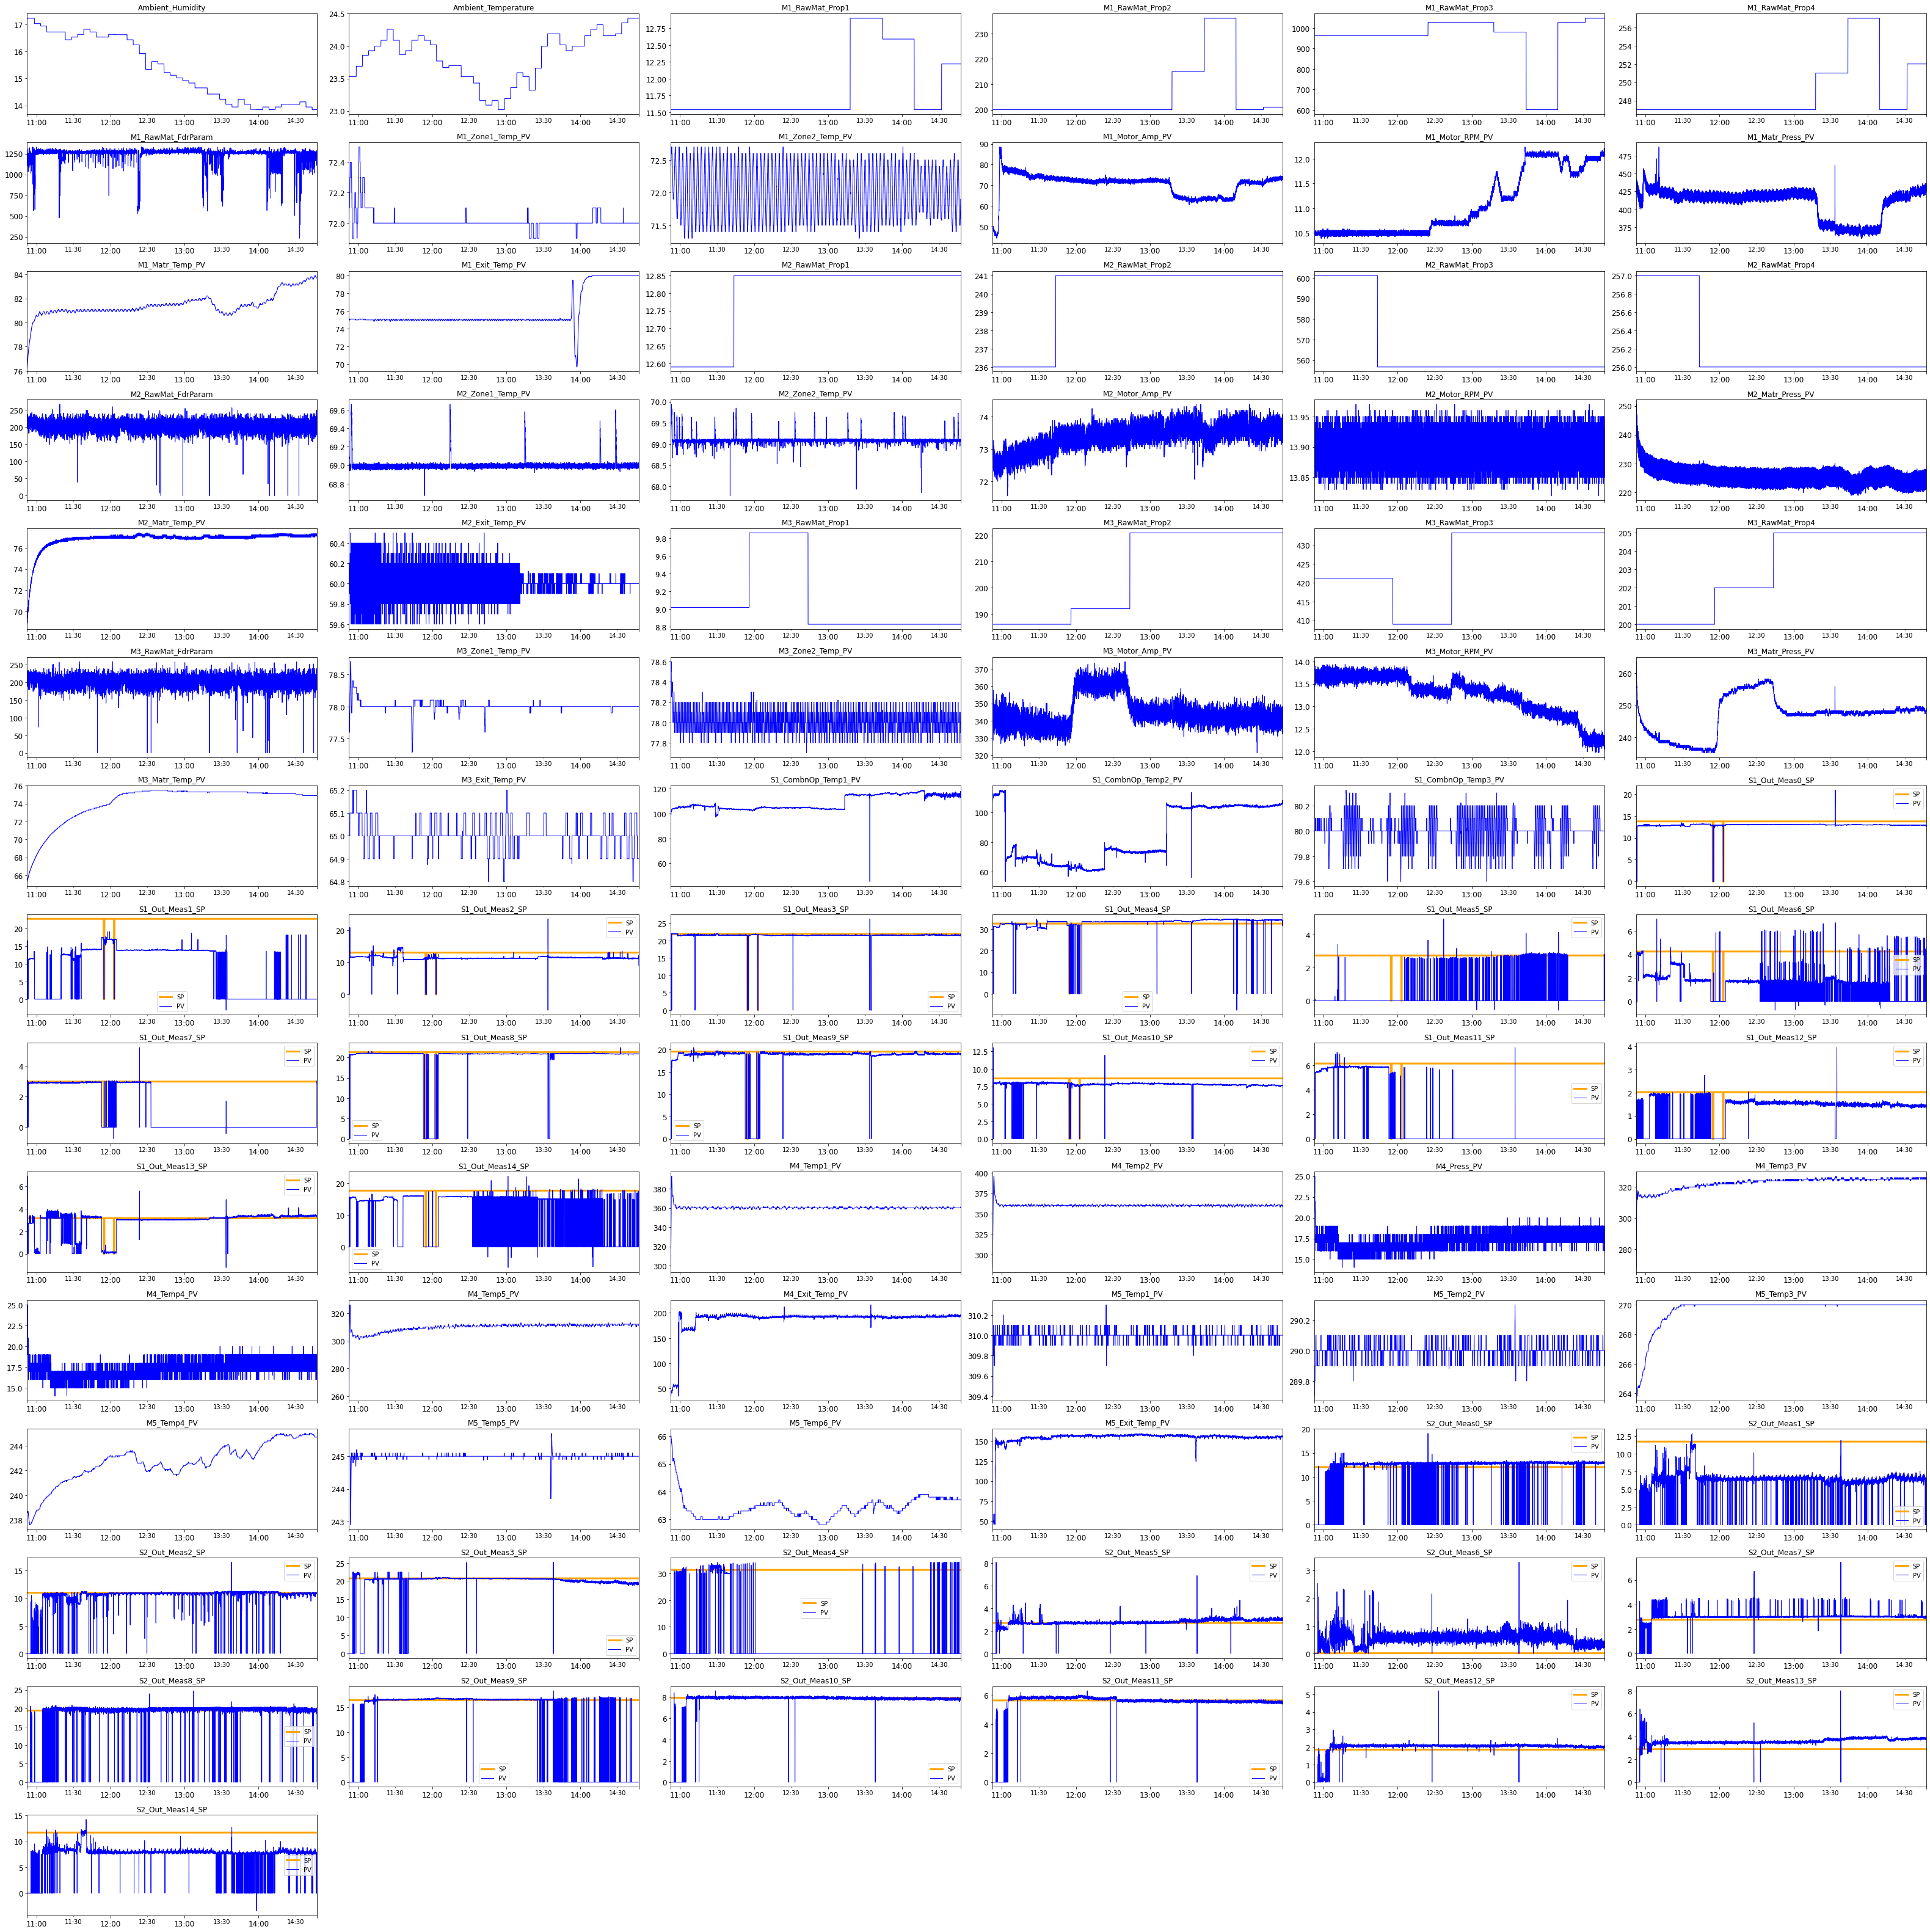

In [51]:
def plot_trends(df):
  # Generate Plots for all columns, with PV and SP columns on the same subplots 
  plotcol_list=df.columns.drop(PV_col_list)
  gspec=gridspec.GridSpec(15,6)
  fig=plt.figure()
  fig.set_size_inches([44,44])
  count=0
  for i in range(0,15):
      for j in range(0,6):
          count+=1
          if count>85:
              break
          thisplot=plt.subplot(gspec[i,j])
          this_col=plotcol_list[count-1]
          if 'SP' in this_col:
            PV_col = this_col[:len(this_col)-2] + 'PV'
            df[this_col].plot(c='orange',linewidth=3,label='SP',legend=True)
            ax=thisplot.figure.gca()
            df[PV_col].plot(c='b',linewidth=1,ax=ax,label='PV',legend=True)
          else:  
            df[this_col].plot(linewidth=1,c='b')
          thisplot.figure.set_size_inches([44,44])
          thisplot.figure.tight_layout(h_pad=1.0)
          thisplot.set_title(f"{this_col}",fontsize=12)
          thisplot.tick_params(axis='y', labelsize=12)
          thisplot.tick_params(axis='x', labelsize=12)     

plot_trends(df)

PDF version of plots has been been saved to Github.

Some observations:
*   SP trends for all 15 S1 measurements show transient dips to 0.0 between 11:54:27 and 11:55:01 (approx 35 secs) and between 12:02:50 and 12:03:10 (approx 20 secs). Multiples dips observed in the S2 measurement sensors (not just during the 2 instances observed for the S1 sensors. 
SPECULATION: the 0.0-dips refer to instances of power supply loss to the sensors, interference from a common external source, or potential sensor reliability issues.
PROPOSAL: to obtain some useful information about the S1 and S2 trends, might consider missing value imputations for the instances of the 0.0-dips
*   Data spikes/dips in multiple measurements, e.g.: M4_Press_PV, M5_Temp2_PV, M2_Motor_RPM_PV, M2_Exit_Temp_PV. These spikes/dips could be due to signal noise. Ranges for these distortions appear to be small compared to the range of the signals themselves.
*   Some S2 meas. trends showing controller saturation, as the PV's are not able to consistently track their SP's, e.g.: S2_Out_Meas0, S2_Out_Meas1, S2_Out_Meas6, S2_Out_Meas13, S2_Out_Meas14
*   Disturbance propagated through multiple S1_Meas sensors between 13:33:37 and 13:33:47 (10 secs)





Next step is to take a closer look at individual plots, and attempt do some clean-up of those with heavy spikes/dips. Need to clean-up these variables before further analyses can be performed on them.

Will first define a function for enlarged plot of any chosen df column. From the enlarged plots, will determine the individual clip limits for the plots with spikes/dips.

Next, will  define a function for removing these spikes/dips and interpolating. Will implement the idea presented in stackoverflow post: https://stackoverflow.com/questions/37556487/remove-spikes-from-signal-in-python

In [52]:
# Define function for individual plots
def plot_big(df_in,linewidth=1):
  global fig
  fig=plt.figure()
  fig.set_size_inches([20,8])
  df_in.plot(linewidth=linewidth,c='b')
  fig.tight_layout(h_pad=1.0)
  col_name=df_in.name
  fig.gca().set_title(f"{col_name}",fontsize=15)
  fig.gca().tick_params(axis='y', labelsize=15)
  fig.gca().tick_params(axis='x', labelsize=15)
  
# Define functions for clipping/interpolation
# DELTA - Distance away from the FBEWMA that data should be removed. 
# HIGH_CLIP - clip data above this value:
# LOW_CLIP - clip data below this value:
# SPAN - How many samples to run the FBEWMA over.
def clip_data(unclipped, high_clip, low_clip):
    ''' Clip unclipped between high_clip and low_clip. 
    unclipped contains a single column of unclipped data.'''
    # convert to np.array to access the np.where method
    np_unclipped = np.array(unclipped)
    # clip data above HIGH_CLIP or below LOW_CLIP
    cond_high_clip = (np_unclipped > high_clip) | (np_unclipped < low_clip)
    np_clipped = np.where(cond_high_clip, np.nan, np_unclipped)
    return pd.Series(np_clipped)
    
def ewma_fb(df_column, span):
    ''' Apply forwards, backwards exponential weighted moving average (EWMA) to df_column. '''
    # Forwards EWMA.
    fwd = pd.Series.ewm(df_column, span=span).mean()
    # Backwards EWMA.
    bwd = pd.Series.ewm(df_column[::-1],span=10).mean()
    # Add and take the mean of the forwards and backwards EWMA.
    stacked_ewma = np.vstack(( fwd, bwd[::-1] ))
    fb_ewma = np.mean(stacked_ewma, axis=0)
    return fb_ewma

def remove_outliers(spikey, fbewma, delta):
    ''' Remove data from df_spikey that is > delta from fbewma. '''
    np_spikey = np.array(spikey)
    np_fbewma = np.array(fbewma)
    cond_delta = (np.abs(np_spikey-np_fbewma) > delta)
    np_remove_outliers = np.where(cond_delta, np.nan, np_spikey)
    return pd.Series(np_remove_outliers,index=df.index)
        
def de_spike(df_in,HIGH_CLIP,LOW_CLIP,SPAN,DELTA,init_pad=False):
    df=df_in.copy(deep=True)
    NAME = df.name
    THE_INDEX = df.index
    df['y_clipped'] = clip_data(df.tolist(), HIGH_CLIP, LOW_CLIP)
    df['y_ewma_fb'] = ewma_fb(df['y_clipped'], SPAN)
    df['y_remove_outliers'] = remove_outliers(df['y_clipped'].tolist(), df['y_ewma_fb'].tolist(), DELTA)
    df['y_interpolated'] = df['y_remove_outliers'].interpolate()
    if init_pad:       # if head values in array are NaN, back-pad array with first good value
      df_pad = df['y_interpolated']
      init_val = df_pad[~df_pad.isnull()][0]
      df['y_interpolated'] = pd.Series(np.where(df_pad.isnull(),init_val,df_pad),index=THE_INDEX)
    df['y_interpolated'].name=NAME
    return df['y_interpolated']
    

In [53]:
# Examine spikes in plots and tune fbewma filter parameters
def examine_spike():
  # Start Time: '2019-03-06 10:52:30'
  # End Time: '2019-03-06 14:47:00'
  col = 'S1_Out_Meas4_PV'
  plot_both=False
  plot_big(df[col],1)
  ax=fig.gca()
  ax.set_xlim(['2019-03-06 10:52:30','2019-03-06 14:47:00']);
  #ax.set_xlim(['2019-03-06 11:50:33','2019-03-06 12:10:00']);
  #ax.set_ylim([25,40]);
  if plot_both:
    de_spike(df[col],70,69.05,5,0.1).plot(ax=ax,c='orange',linewidth=2,legend=True)
  #df['S1_CombnOp_Temp1_PV'].rolling(window=30,
  #                                 center=True,
  #                                 min_periods=15).mean().plot(ax=ax,c='red',linewidth=2,legend=True)
  #df_nospke['S1_Out_Meas5_PV'].plot(ax=ax,c='red',linewidth=2,legend=True)
  #df_nospke[col].plot(ax=ax,c='red',linewidth=2,legend=True)

#examine_spike()

In [54]:
# Define dict for despiking filter parameters
despike_dict={}
despike_dict['VARIABLE']=['M1_RawMat_FdrParam','M1_Matr_Press_PV','M2_RawMat_FdrParam','M3_RawMat_FdrParam','S1_CombnOp_Temp1_PV',
                          'S1_CombnOp_Temp2_PV','S1_Out_Meas0_PV','S1_Out_Meas0_SP','S1_Out_Meas1_PV','S1_Out_Meas1_SP','S1_Out_Meas2_PV',
                          'S1_Out_Meas2_SP','S1_Out_Meas3_PV','S1_Out_Meas3_SP','S1_Out_Meas4_PV','S1_Out_Meas4_SP','S1_Out_Meas5_PV',
                          'S1_Out_Meas5_SP','S1_Out_Meas6_PV','S1_Out_Meas6_SP','S1_Out_Meas7_PV','S1_Out_Meas7_SP','M2_Motor_Amp_PV',
                          'S1_Out_Meas8_PV','S1_Out_Meas8_SP','S1_Out_Meas9_PV','S1_Out_Meas9_SP','S1_Out_Meas10_PV','S1_Out_Meas10_SP',
                          'S1_Out_Meas11_PV','S1_Out_Meas11_SP','S1_Out_Meas12_PV','S1_Out_Meas12_SP','S1_Out_Meas13_PV','S1_Out_Meas13_SP',
                          'S1_Out_Meas14_PV','S1_Out_Meas14_SP','M2_Zone1_Temp_PV','M2_Zone2_Temp_PV']
despike_dict['HIGH_CLIP']=[1350,470,250,240,120,120,15,15,19,30,16,16,23,23,35,35,2.9,2.9,4.3,4.3,3.5,3.5,74.5,21.2,22,20,20,8.25,8.75,6.1,6.3,
                           2.05,2.05,4.1,4.1,16.3,18,69.8,70]
despike_dict['LOW_CLIP']=[500,360,120,160,90,50,10,10,10,10,10,10,20,20,28,28,2,2,1.3,1.3,2.8,2.8,71.5,20.7,20.7,17,17,7.1,7.1,5,5,1.25,1.25,0.05,
                          0.05,14,14,68.8,69.05]
despike_dict['SPAN']=[5,5,5,5,5,5,10,10,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,10,10,5,5,5,5,5,5,5,5,5,5]
despike_dict['DELTA']=[50,10,80,50,20,5,0.2,0.2,1,1,0.2,0.2,0.05,0.05,1,1,0.5,0.5,0.1,0.1,1,1,0.1,0.1,0.1,0.08,0.08,0.05,0.05,0.1,0.1,0.02,0.02,
                       0.4,0.4,0.05,0.05,0.2,0.1]
despike_dict['INIT_PAD']=[False,False,False, False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,
                          False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False]


From a close examination of individual plots, there are some signals which, though noisy/spiky, have weakly-stationary trends for the time range of the dataset. Their stationarity was also observed from the plots of their rolling averages (calculated to help suppress noise and highlight any longer-term trends). Additionally, the noise/spike ranges of these signals are too small wrt to the order of magnitude of each signal to be considered meaningful (e.g. 0.3 deg noise amplitude for ~300 deg signal).  Consideration here is that these signals are not likely to provide much useful insight. These signals will be dropped from subsequent analyses and modeling calculations. The signals are:
*   M2_Motor_RPM_PV
*   M2_Exit_Temp_PV
*   M3_Exit_Temp_PV
*   S1_CombnOp_Temp3_PV
*   M5_Temp1_PV
*   M5_Temp2_PV




In [55]:
# Rebuild dataframe of de-spiked trends
statnry_col = ['M2_Motor_RPM_PV','M2_Exit_Temp_PV','M3_Exit_Temp_PV','S1_CombnOp_Temp3_PV','M5_Temp1_PV','M5_Temp2_PV']
def despiked_df():
    df_nospke=pd.DataFrame()
    for col in df.columns:
        if col in despike_dict['VARIABLE']:
            i = despike_dict['VARIABLE'].index(col)
            df_nospke[col]=de_spike(df[col],
                                    despike_dict['HIGH_CLIP'][i],
                                    despike_dict['LOW_CLIP'][i],
                                    despike_dict['SPAN'][i],
                                    despike_dict['DELTA'][i],
                                    despike_dict['INIT_PAD'][i])
        #elif col in statnry_col:
        #  continue
        else:
            df_nospke[col]=df[col]
    return df_nospke

df_nospke = despiked_df()

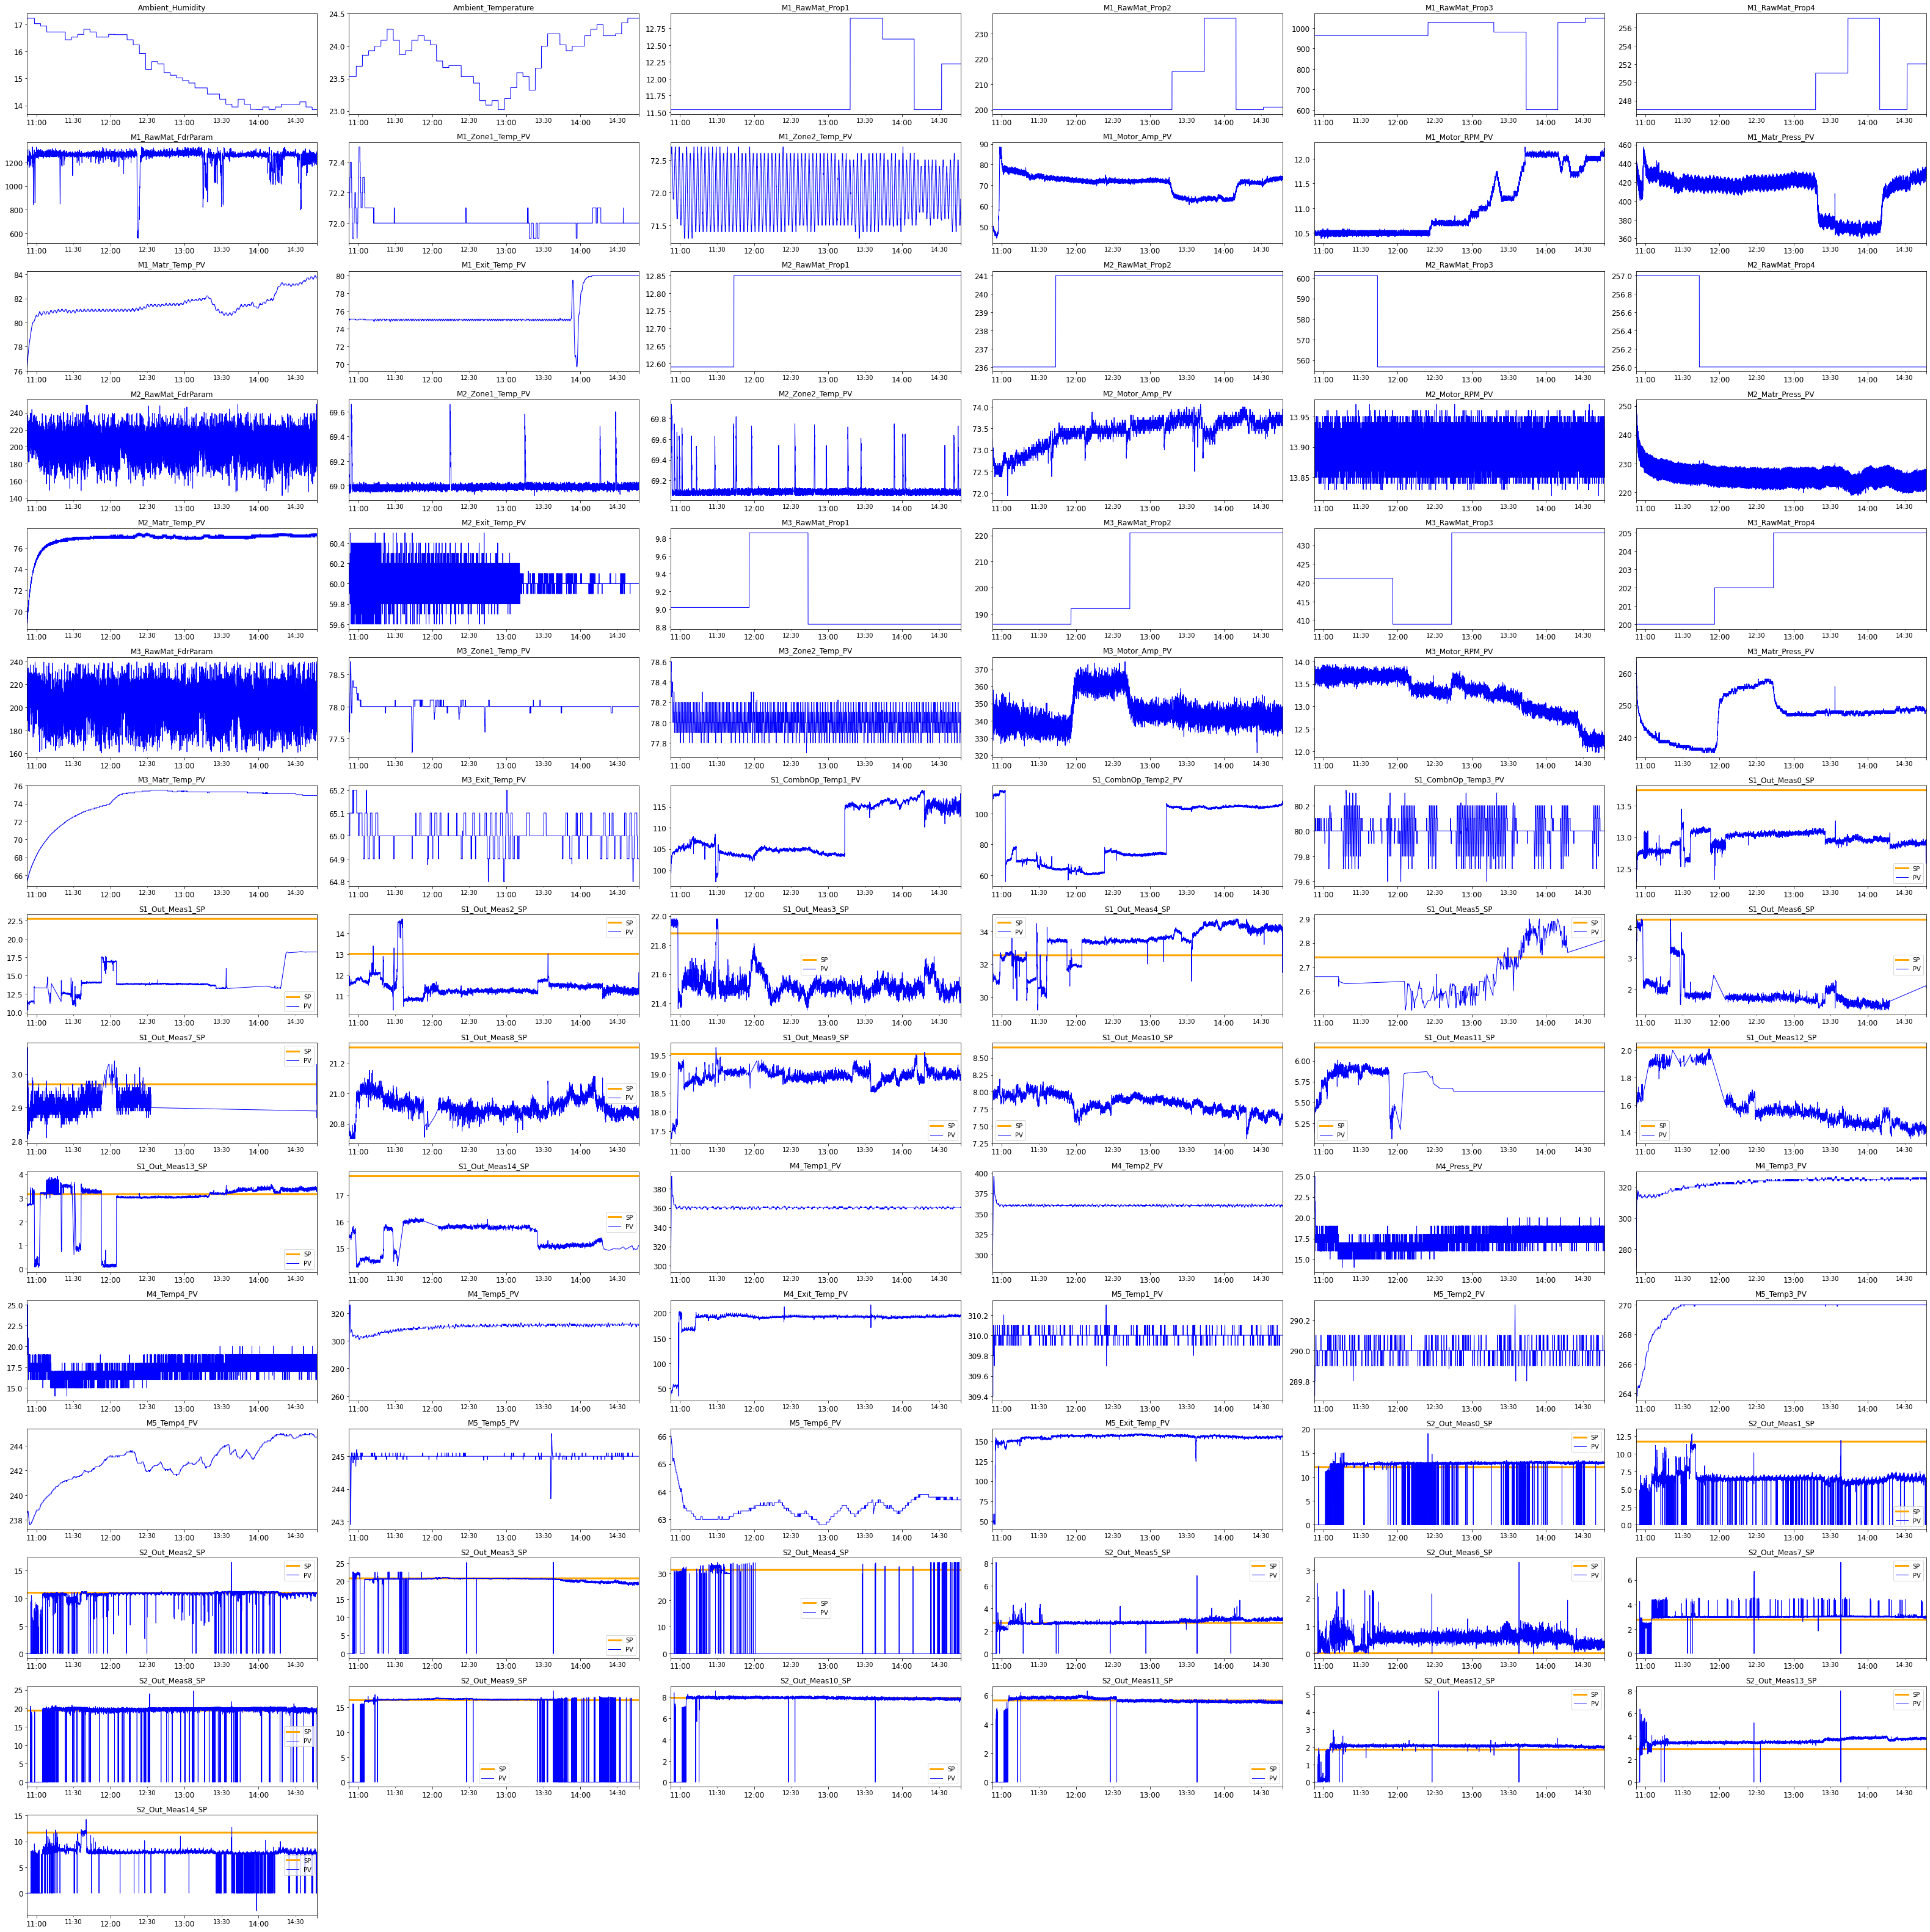

In [56]:
plot_trends(df_nospke)

Recall the primary objective is to predict measurements of output from Stage 1 (consisting of Machines 1, 2, 3, and the Combiner), hence predict S1_Out_Meas0_PV to S1_Out_Meas14_PV from the production line's various input data. We therefore seek to build model(s) having S1_Out_Meas0_PV to S1_Out_Meas14_PV as the target variables.

Note that even though the setpoint (SP) data for the Stage 1 output PV measurements have been included in the dataset, a review of the plots of the combined SP/PV trends for the 15 output measurements indicates that the PV's are barely in control, i.e. not tracking their corresponding SP's. The problem statement does not contain adequate information about the control status of the 15 variables during the timestamp range of the dataset (open-loop or closed-loop?). However, the non-tracking of the 15 PV's to their SP's suggests their control status being open-loop during the production run.  In the absence of addition information in the problem statement to provide confirmation, it will be assumed that the 15 PV's are open-loop. This implies the 15 SP trends (all flat, except during the spike instances) will not be useful in providing information about the PV's.

The problem statement indicates that the manufacturing process on the production line is high-speed and continuous. From the process flow diagram sketched for the production line, Stage 2 (consisting of Machines 4 & 5) is downstream of the Stage 1 outputs. As there is no mention of any recycle to the upstream sections of the production line, it will be assumed that Stage 1 is strictly upstream in series to Stage 2 without any feedback interaction from Stage 2 back to Stage 1. Hence, subsequent EDA for modeling the Stage 1 outputs will not include the Stage 2 variables as potential input features. EDA will therefore be restricted to the following variables:

*   Ambient_Humidity
*   Ambient_Temperature
*   M1_RawMat_Prop1
*   M1_RawMat_Prop2
*   M1_RawMat_Prop3
*   M1_RawMat_Prop4
*   M1_RawMat_FdrParam
*   M1_Zone1_Temp_PV
*   M1_Zone2_Temp_PV
*   M1_Motor_Amp_PV
*   M1_Motor_RPM_PV
*   M1_Matr_Press_PV
*   M1_Matr_Temp_PV
*   M1_Exit_Temp_PV
*   M2_RawMat_Prop1
*   M2_RawMat_Prop2
*   M2_RawMat_Prop3
*   M2_RawMat_Prop4
*   M2_RawMat_FdrParam
*   M2_Zone1_Temp_PV
*   M2_Zone2_Temp_PV
*   M2_Motor_Amp_PV
*   M2_Motor_RPM_PV
*   M2_Matr_Press_PV
*   M2_Matr_Temp_PV
*   M2_Exit_Temp_PV
*   M3_RawMat_Prop1
*   M3_RawMat_Prop2
*   M3_RawMat_Prop3
*   M3_RawMat_Prop4
*   M3_RawMat_FdrParam
*   M3_Zone1_Temp_PV
*   M3_Zone2_Temp_PV
*   M3_Motor_Amp_PV
*   M3_Motor_RPM_PV
*   M3_Matr_Press_PV
*   M3_Matr_Temp_PV
*   M3_Exit_Temp_PV
*   S1_CombnOp_Temp1_PV
*   S1_CombnOp_Temp2_PV
*   S1_CombnOp_Temp3_PV

Before diving into deeper correlation analyses, will first compute the Mutual Information dataframe between the proposed model targets and input features to identify the target-feature relationships not worth exploring further. Any MI value for a target-input feature target = 0.0 will be dropped from the feature set.

In [57]:
# Define function for calculating Mutual Information (MI) between any 2 variables
def mi_score(X,y):
  X=pd.DataFrame(X)
  return mutual_info_regression(X,y,discrete_features=False)[0]

# Define function for calculating lagged cross correlation between any 2 variables
def lagged_cross_corr(X,y,max_lag,sbplot):
  X=pd.DataFrame(X)
  corr_lagd = [y.corr(X.shift(t).fillna(X.squeeze().values[0]).squeeze()) for t in range(0,max_lag)]
  corr_lagd = pd.Series(corr_lagd,index=range(0,max_lag),name=X.columns[0])
  sbplot.bar(corr_lagd.index,corr_lagd,align='center',width=0.8)
  sbplot.set_xlabel('Lags',fontsize=7)
  sbplot.set_ylabel(f"{X.columns[0]}",fontsize=7)
  sbplot.set_title(f"{y.name} ({max_lag-1} lags)",fontsize=7)
  sbplot.set_ylim(-1.0,1.1)

# Create dataframe of MI scores between targets and input features
downstrm_col = [col for col in df_nospke.columns if 'M4_' in col or 'M5_' in col or 'S2_' in col]
feat_list = df_nospke.columns.difference(PV_col_list+SP_col_list+downstrm_col+statnry_col)
PV_S1_col_list = [col1 for col1 in PV_col_list if 'S2_' not in col1]
df_mi_scores = pd.DataFrame(index=feat_list)
for col in PV_S1_col_list:
  mi_list = []
  for idx in feat_list:
    mi_list.append(mi_score(df_nospke[idx],df_nospke[col]))
  df_mi_scores = pd.concat([df_mi_scores,pd.Series(mi_list,index=feat_list,name=col)],axis=1)  
display(df_mi_scores)

S1_Out_Meas0_PV  S1_Out_Meas1_PV  S1_Out_Meas2_PV  \
Ambient_Humidity            1.036650         1.719227         0.998265   
Ambient_Temperature         0.987831         1.693819         0.927990   
M1_Exit_Temp_PV             0.334567         0.818692         0.236944   
M1_Matr_Press_PV            0.378532         0.685202         0.393507   
M1_Matr_Temp_PV             0.678951         1.496475         0.646787   
M1_Motor_Amp_PV             0.630272         1.009260         0.674696   
M1_Motor_RPM_PV             0.684184         1.169328         0.541606   
M1_RawMat_FdrParam          0.099055         0.180494         0.091015   
M1_RawMat_Prop1             0.346871         0.694513         0.275245   
M1_RawMat_Prop2             0.246290         0.488484         0.243213   
M1_RawMat_Prop3             0.492139         0.926548         0.459091   
M1_RawMat_Prop4             0.293758         0.569518         0.219432   
M1_Zone1_Temp_PV            0.156636         0.273317         0.171511   
M1_Zone2_Temp_PV            0.080628         0.652373         0.133162   
M2_Matr_Press_PV            0.219538         0.294372         0.217903   
M2_Matr_Temp_PV             0.441691         0.678964         0.464288   
M2_Motor_Amp_PV             0.477463         0.828926         0.492690   
M2_RawMat_FdrParam          0.013699         0.017467         0.005237   
M2_RawMat_Prop1             0.266110         0.349292         0.273195   
M2_RawMat_Prop2             0.277509         0.360351         0.275822   
M2_RawMat_Prop3             0.262457         0.348140         0.278591   
M2_RawMat_Prop4             0.276393         0.358882         0.276662   
M2_Zone1_Temp_PV            0.027364         0.063477         0.035296   
M2_Zone2_Temp_PV            0.044039         0.088002         0.048109   
M3_Matr_Press_PV            0.809830         1.242196         0.796628   
M3_Matr_Temp_PV             1.078791         1.820441         1.107663   
M3_Motor_Amp_PV             0.245991         0.392309         0.238866   
M3_Motor_RPM_PV             0.663207         1.053039         0.545699   
M3_RawMat_FdrParam          0.004352         0.034351         0.006928   
M3_RawMat_Prop1             0.411869         0.622617         0.421804   
M3_RawMat_Prop2             0.223973         0.363663         0.173000   
M3_RawMat_Prop3             0.396783         0.615972         0.401114   
M3_RawMat_Prop4             0.421176         0.627561         0.409783   
M3_Zone1_Temp_PV            0.122086         0.266704         0.145410   
M3_Zone2_Temp_PV            0.056213         0.335784         0.076596   
S1_CombnOp_Temp1_PV         0.852029         1.439478         0.794587   
S1_CombnOp_Temp2_PV         0.938530         1.448700         0.945917   

                     S1_Out_Meas3_PV  S1_Out_Meas4_PV  S1_Out_Meas5_PV  \
Ambient_Humidity            0.464639         1.456666         1.886318   
Ambient_Temperature         0.446038         1.332486         1.791072   
M1_Exit_Temp_PV             0.090440         0.543075         0.796505   
M1_Matr_Press_PV            0.087337         0.447910         0.698579   
M1_Matr_Temp_PV             0.350436         1.056700         1.543050   
M1_Motor_Amp_PV             0.226505         0.767797         1.028578   
M1_Motor_RPM_PV             0.221615         1.100769         1.342181   
M1_RawMat_FdrParam          0.062448         0.150103         0.221527   
M1_RawMat_Prop1             0.067797         0.457351         0.665382   
M1_RawMat_Prop2             0.042094         0.313186         0.474413   
M1_RawMat_Prop3             0.130572         0.723499         0.992837   
M1_RawMat_Prop4             0.079249         0.386803         0.568526   
M1_Zone1_Temp_PV            0.084148         0.233521         0.241743   
M1_Zone2_Temp_PV            0.051866         0.235719         0.884952   
M2_Matr_Press_PV            0.095655         0.260954         0.290312   
M2_Matr_Temp_PV         

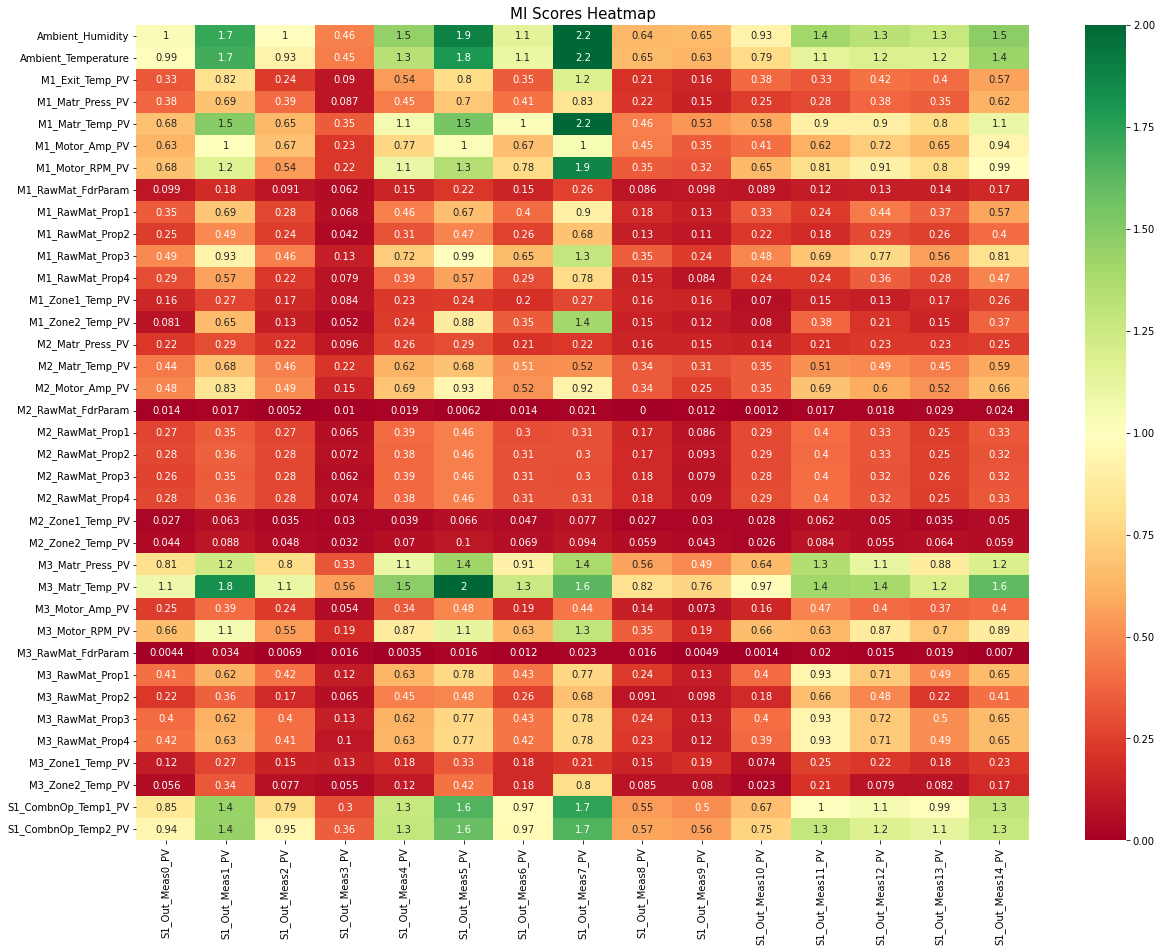

In [58]:
# Examine heatmap for MI score dataframe
plt.figure(figsize=(20,15))
g1 = sns.heatmap(df_mi_scores,annot=True,cmap="RdYlGn",vmin=0.0,vmax=2.0)
g1.set_title('MI Scores Heatmap',fontsize=15);

From the MI Scores heatmap, it would appear having information on both Ambient Temperature and Humidity have significant impact in reducing the uncertainty in the 12 out of the 15 Stage 1 output measurements. Other impactful features across the board appear to be the Machine 1 and Machine 3 Motor variables and machine material/exit conditions. Although Machine 2 has some uncertainty reduction impact on some Stage 1 outputs, overall, it does not appear to be as strong as Machines 1 & 3. This could be due to relatively less movement in the Machine 2 variables (Motor, Raw Material, etc) compared to the other 2 machines.

No target/feature pair has a 0.0  MI score, however, there are numerous low values. S1_Out_Meas3/8/9_PV appear to not have significant uncertainty reduction from the input features.

The significant impact from the 2 Stage 1 Combiner temperatures is not surprising since the temperatures are directly upstream of the output measurement points. However, these 2 temperatures are downstream of the other input features; some relationship/correlation is therefore to be expected between the 2 temperatures and the upstream variables. The 2 Combiner temperatures should therefore not be considered as independent input features.

Since the heatmap above examines uncertainty reduction amongst the variables, and not correlation strength with the Stage 1 outputs, care should be taken not to interpret the numbers above as the key criteria for feature selection. The MI scores, for eaxmple, do not provide insight to the relationship direction (i.e. positive or negative) in the target-feature pairs.

Next, will examine the correlation matrices amongst the variables: both between the targets and the input features, and amongt the features

In [59]:
# Create dataframe of correlations between targets and input features
df_corr = pd.DataFrame(index=feat_list)
for col in PV_S1_col_list:
  corr_list = []
  for idx in feat_list:
    corr_list.append(df_nospke[col].corr(df_nospke[idx], method="pearson"))
  df_corr = pd.concat([df_corr,pd.Series(corr_list,index=feat_list,name=col)],axis=1)  
display(df_corr)


S1_Out_Meas0_PV  S1_Out_Meas1_PV  S1_Out_Meas2_PV  \
Ambient_Humidity           -0.185675        -0.322630         0.143655   
Ambient_Temperature        -0.386533         0.339416         0.114696   
M1_Exit_Temp_PV            -0.166125         0.571817        -0.089981   
M1_Matr_Press_PV           -0.115534         0.221261        -0.029320   
M1_Matr_Temp_PV             0.138331         0.707380        -0.207662   
M1_Motor_Amp_PV             0.009119         0.219689         0.025147   
M1_Motor_RPM_PV            -0.001310         0.346824        -0.082872   
M1_RawMat_FdrParam         -0.016273         0.010023         0.015849   
M1_RawMat_Prop1             0.033802        -0.013064         0.036470   
M1_RawMat_Prop2             0.048018        -0.185593         0.048467   
M1_RawMat_Prop3             0.038123         0.249589        -0.087283   
M1_RawMat_Prop4             0.001684         0.041340         0.013509   
M1_Zone1_Temp_PV           -0.314804        -0.174473         0.146087   
M1_Zone2_Temp_PV           -0.057350        -0.038508         0.056719   
M2_Matr_Press_PV           -0.335091        -0.317011         0.170718   
M2_Matr_Temp_PV             0.440872         0.337019        -0.174520   
M2_Motor_Amp_PV             0.451789         0.387135        -0.316758   
M2_RawMat_FdrParam         -0.011202        -0.042024        -0.021989   
M2_RawMat_Prop1             0.506959         0.430259        -0.458546   
M2_RawMat_Prop2             0.506959         0.430259        -0.458546   
M2_RawMat_Prop3            -0.506959        -0.430259         0.458546   
M2_RawMat_Prop4            -0.506959        -0.430259         0.458546   
M2_Zone1_Temp_PV           -0.022337        -0.002607        -0.027828   
M2_Zone2_Temp_PV           -0.059322        -0.026344        -0.035477   
M3_Matr_Press_PV            0.285094         0.167079        -0.266015   
M3_Matr_Temp_PV             0.589107         0.340495        -0.328788   
M3_Motor_Amp_PV             0.272121         0.038446        -0.199089   
M3_Motor_RPM_PV             0.001749        -0.588886         0.154483   
M3_RawMat_FdrParam         -0.014733        -0.053347        -0.006739   
M3_RawMat_Prop1             0.144326        -0.000155        -0.133489   
M3_RawMat_Prop2             0.214158         0.285776        -0.160619   
M3_RawMat_Prop3            -0.004645         0.124394         0.020587   
M3_RawMat_Prop4             0.275121         0.321147        -0.212363   
M3_Zone1_Temp_PV           -0.171826        -0.116967         0.051501   
M3_Zone2_Temp_PV           -0.089109        -0.051465         0.012113   
S1_CombnOp_Temp1_PV        -0.093665         0.246984         0.001065   
S1_CombnOp_Temp2_PV        -0.198575         0.149404         0.032306   

                     S1_Out_Meas3_PV  S1_Out_Meas4_PV  S1_Out_Meas5_PV  \
Ambient_Humidity            0.314852        -0.764211        -0.695641   
Ambient_Temperature         0.002781         0.072198         0.634101   
M1_Exit_Temp_PV            -0.057358         0.431648         0.624812   
M1_Matr_Press_PV            0.138798        -0.439836        -0.608493   
M1_Matr_Temp_PV            -0.355197         0.555724         0.421687   
M1_Motor_Amp_PV            -0.320558        -0.205725        -0.402372   
M1_Motor_RPM_PV            -0.205817         0.717903         0.891623   
M1_RawMat_FdrParam          0.028627        -0.061649        -0.015287   
M1_RawMat_Prop1            -0.214744         0.453893         0.627371   
M1_RawMat_Prop2            -0.149500         0.441016         0.658753   
M1_RawMat_Prop3             0.037144        -0.235383        -0.532285   
M1_RawMat_Prop4            -0.193893         0.507372         0.755977   
M1_Zone1_Temp_PV            0.212135        -0.212561        -0.002022   
M1_Zone2_Temp_PV            0.056479        -0.044326         0.004155   
M2_Matr_Press_PV            0.392820        -0.424208        -0.178664   
M2_Matr_Temp_PV         

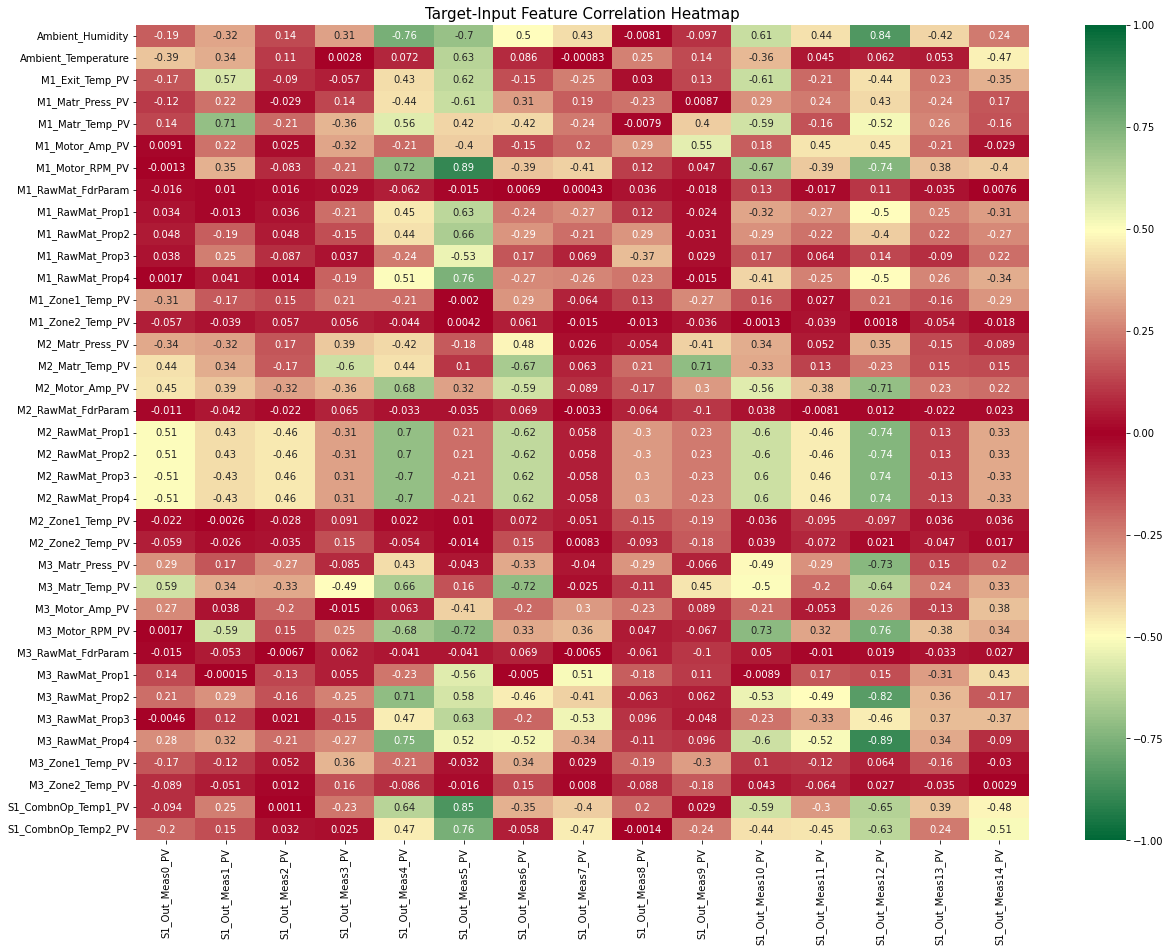

In [60]:
# Examine heatmap for Target-Feature Correlation dataframe
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    name='corrcmap', 
    colors=['#006837','#fffebe','#a50026','#fffebe','#006837']
)
plt.figure(figsize=(20,15))
g2 = sns.heatmap(df_corr,annot=True,cmap=cmap,vmin=-1.0,vmax=1.0)
g2.set_title('Target-Input Feature Correlation Heatmap',fontsize=15);

In [61]:
# Plot Lagged Cross-correlations between targets and input features
# This is to help determine if, in addition zero-lag cross correlations already computed,
# there are lagged correlations in the target-input feature pairs that give higher values 
def lagged_corr_plot():
  gspec=gridspec.GridSpec(len(feat_list),len(PV_S1_col_list))
  fig=plt.figure()
  fig.set_size_inches([44,84])
  count=0
  for i in range(0,len(feat_list)):
      for j in range(0,len(PV_S1_col_list)):
          count+=1
          if count>len(feat_list)*len(PV_S1_col_list):
              break
          thisplot=plt.subplot(gspec[i,j])
          lagged_cross_corr(df_nospke[feat_list[i]].diff(),df_nospke[PV_S1_col_list[j]].diff(),5,thisplot)
          thisplot.figure.set_size_inches([44,84])
          thisplot.figure.tight_layout(h_pad=1.0)
#### NOTE: Please run this function sparingly...takes about 45 mins to run for 4 lags!!
#lagged_corr_plot()

Next, will investigate cross-correlations amongst the features. If there are correlated features in the list, they should not both/all be included in the model trainings. Some mathematical transformations, e.g. summing the features, may be required.

In [62]:
# Calculate correlations amongst features
# S1_CombnOp_Temp1_PV and S1_CombnOp_Temp2_PV will be left out of the list for this calculation, as
# we expect them to be correlated with the other features
feat_list2=feat_list.difference(['S1_CombnOp_Temp1_PV','S1_CombnOp_Temp2_PV'])
df_featcorr = pd.DataFrame(index=feat_list2)
for col in feat_list2:
  corr_list = []
  for idx in feat_list2:
    corr_list.append(df_nospke[col].corr(df_nospke[idx], method="pearson"))
  df_featcorr = pd.concat([df_featcorr,pd.Series(corr_list,index=feat_list2,name=col)],axis=1)  
display(df_featcorr)

Ambient_Humidity  Ambient_Temperature  M1_Exit_Temp_PV  \
Ambient_Humidity             1.000000            -0.197401        -0.530926   
Ambient_Temperature         -0.197401             1.000000         0.523745   
M1_Exit_Temp_PV             -0.530926             0.523745         1.000000   
M1_Matr_Press_PV             0.565678            -0.216512        -0.004307   
M1_Matr_Temp_PV             -0.649393             0.297221         0.725663   
M1_Motor_Amp_PV              0.373958             0.002999        -0.002584   
M1_Motor_RPM_PV             -0.906481             0.442081         0.636046   
M1_RawMat_FdrParam           0.050588            -0.066236        -0.086549   
M1_RawMat_Prop1             -0.634965             0.260897         0.086599   
M1_RawMat_Prop2             -0.530235             0.190859         0.025919   
M1_RawMat_Prop3              0.222924            -0.208466         0.043204   
M1_RawMat_Prop4             -0.619726             0.322569         0.212597   
M1_Zone1_Temp_PV             0.275358             0.012758         0.016389   
M1_Zone2_Temp_PV             0.021222            -0.007012         0.009942   
M2_Matr_Press_PV             0.429913            -0.063429        -0.176799   
M2_Matr_Temp_PV             -0.421316             0.145710         0.171722   
M2_Motor_Amp_PV             -0.753520             0.018162         0.369099   
M2_RawMat_FdrParam           0.068874            -0.039309        -0.052152   
M2_RawMat_Prop1             -0.649495            -0.106470         0.242980   
M2_RawMat_Prop2             -0.649495            -0.106470         0.242980   
M2_RawMat_Prop3              0.649495             0.106470        -0.242980   
M2_RawMat_Prop4              0.649495             0.106470        -0.242980   
M2_Zone1_Temp_PV            -0.029080            -0.022986         0.059474   
M2_Zone2_Temp_PV             0.077347            -0.038646         0.004050   
M3_Matr_Press_PV            -0.349767            -0.373122         0.116673   
M3_Matr_Temp_PV             -0.667613            -0.086899         0.198900   
M3_Motor_Amp_PV              0.123688            -0.415579        -0.202711   
M3_Motor_RPM_PV              0.821789            -0.432849        -0.762882   
M3_RawMat_FdrParam           0.071639            -0.047673        -0.048866   
M3_RawMat_Prop1              0.510488            -0.257414        -0.306911   
M3_RawMat_Prop2             -0.939665             0.025870         0.437078   
M3_RawMat_Prop3             -0.754554             0.185660         0.398038   
M3_RawMat_Prop4             -0.934318            -0.032329         0.418021   
M3_Zone1_Temp_PV             0.190348            -0.051630        -0.061554   
M3_Zone2_Temp_PV             0.071170            -0.016248        -0.022533   

                     M1_Matr_Press_PV  M1_Matr_Temp_PV  M1_Motor_Amp_PV  \
Ambient_Humidity             0.565678        -0.649393         0.373958   
Ambient_Temperature         -0.216512         0.297221         0.002999   
M1_Exit_Temp_PV             -0.004307         0.725663        -0.002584   
M1_Matr_Press_PV             1.000000         0.075464         0.673133   
M1_Matr_Temp_PV              0.075464         1.000000         0.259590   
M1_Motor_Amp_PV              0.673133         0.259590         1.000000   
M1_Motor_RPM_PV             -0.586460         0.628453        -0.403894   
M1_RawMat_FdrParam           0.019891        -0.038299         0.050652   
M1_RawMat_Prop1             -0.824634         0.084999        -0.596093   
M1_RawMat_Prop2             -0.868953        -0.036090        -0.581848   
M1_RawMat_Prop3              0.674274         0.172377         0.417044   
M1_RawMat_Prop4             -0.770875         0.176758        -0.522473   
M1_Zone1_Temp_PV             0.223612        -0.271588         0.058101   
M1_Zone2_Temp_PV            -0.012434        -0.015028        -0.055752   
M2_Matr_Press_PV             0.223090        -0.478

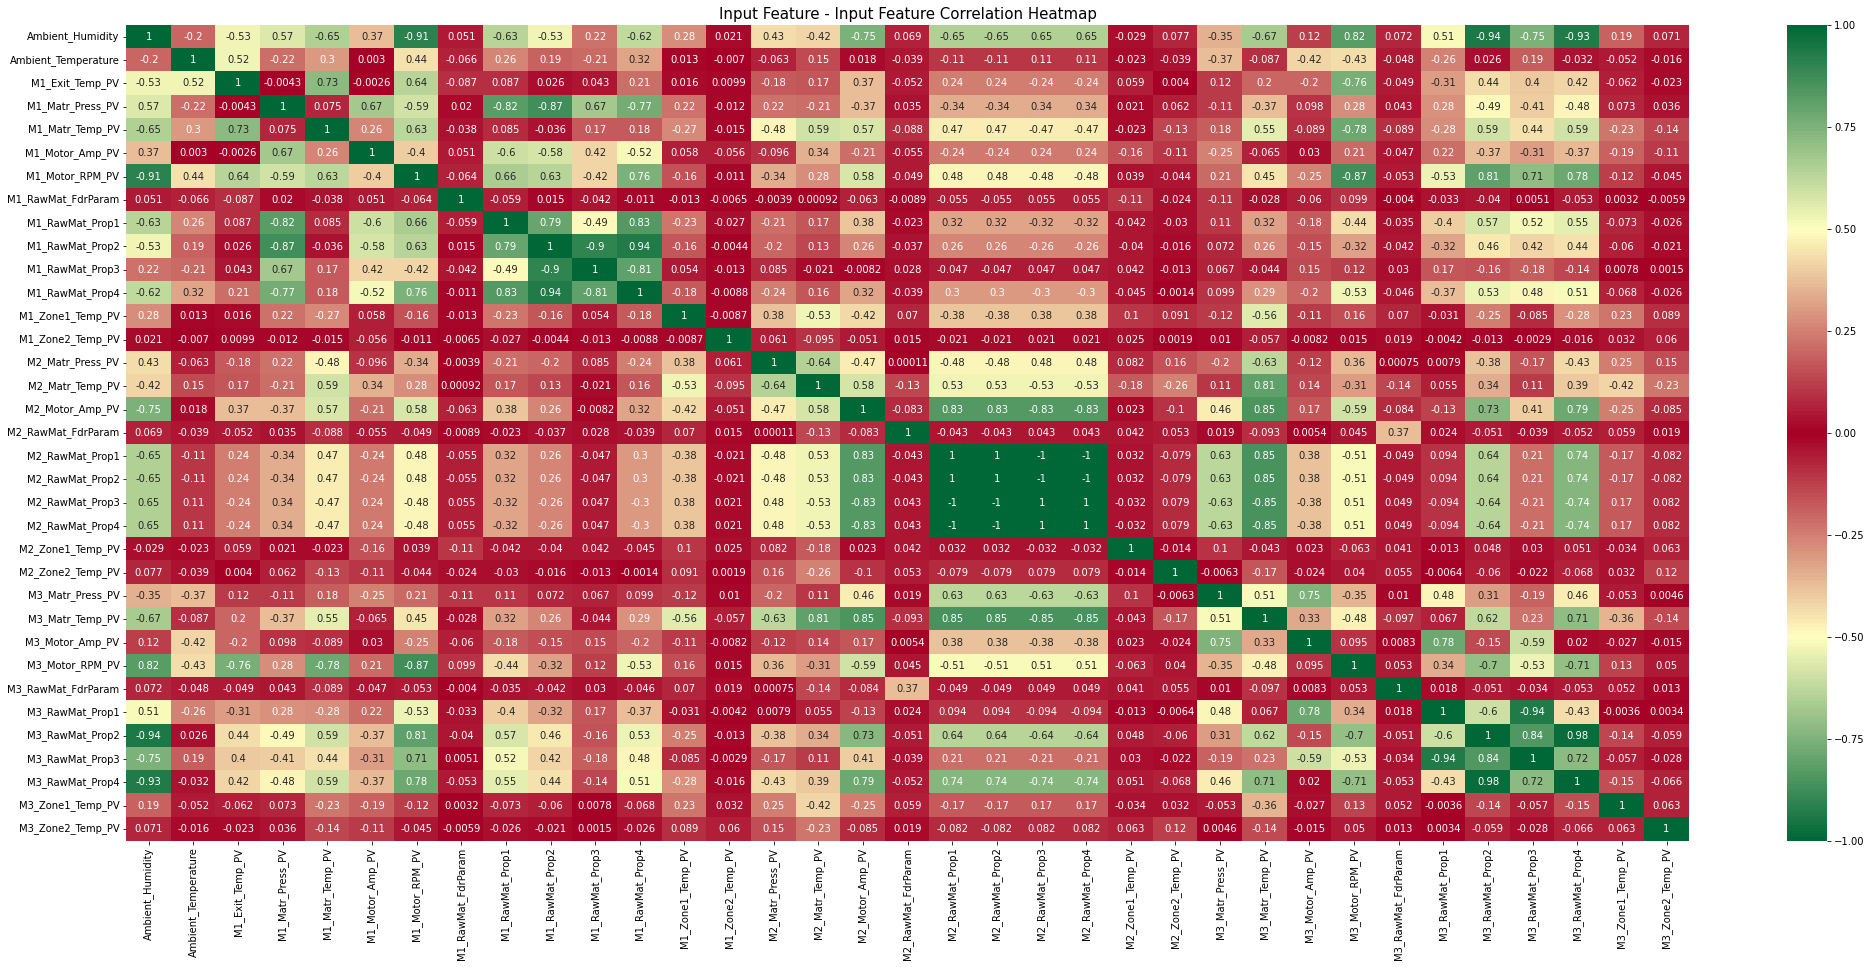

In [63]:
# Plot heatmap of features cross-correlation
plt.figure(figsize=(35,15))
g3 = sns.heatmap(df_featcorr,annot=True,cmap=cmap,vmin=-1.0,vmax=1.0)
g3.set_title('Input Feature - Input Feature Correlation Heatmap',fontsize=15);

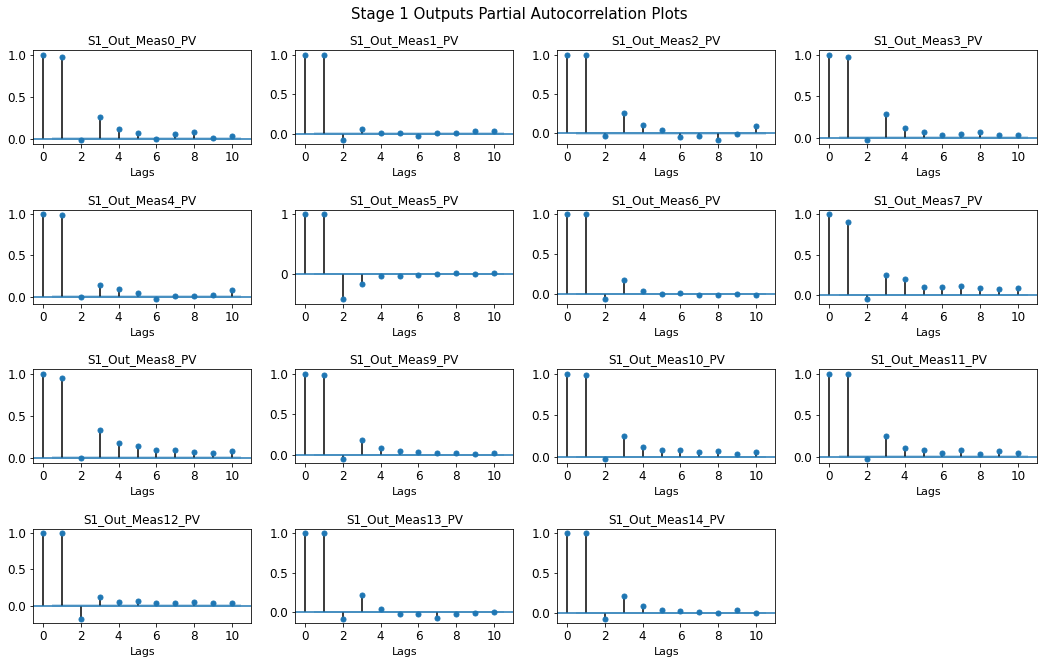

In [64]:
# Plot PACF for Stage 1 Output Measurements
gspec=gridspec.GridSpec(4,4)
fig=plt.figure()
fig.set_size_inches([90,72])
fig.suptitle('Stage 1 Outputs Partial Autocorrelation Plots',fontsize=15)
fig.subplots_adjust(top=0.92,hspace=0.7)
count=0
for i in range(0,4):
    for j in range(0,4):
        count+=1
        if count>15:
            break
        thisplot=plt.subplot(gspec[i,j])
        this_col=PV_S1_col_list[count-1]
        plot_pacf(df_nospke[this_col],lags=10,ax=thisplot)
        thisplot.figure.set_size_inches([18,10])
        thisplot.set_title(f"{this_col}",fontsize=12)
        thisplot.tick_params(axis='y', labelsize=12)
        thisplot.tick_params(axis='x', labelsize=12)
        thisplot.set_xlabel('Lags',fontsize=11)

The PACF's appear to show that the S1 output measurements show some correlation up to their respective 3-sec lagged trends.

Add some commentary here about conclusions from all the heatmaps and correlation plots....

In [65]:
# Create some calculated features to be used in the system identification
df_nospke['M1_RawMat_PropSum'] = df_nospke[[f"M1_RawMat_Prop{i}" for i in range(1,5)]].sum(axis=1)
df_nospke['M2_RawMat_PropSum'] = df_nospke[[f"M2_RawMat_Prop{i}" for i in range(1,5)]].sum(axis=1)
df_nospke['M3_RawMat_PropSum'] = df_nospke[[f"M3_RawMat_Prop{i}" for i in range(1,5)]].sum(axis=1)
# PROBABLY SHOULD USE PCA HERE??

# Collate features list for system identification
u_list = ['Ambient_Temperature','Ambient_Humidity','M1_Motor_Amp_PV','M1_Matr_Press_PV','M1_Matr_Temp_PV','M1_RawMat_PropSum',
          'M2_Motor_Amp_PV','M2_Matr_Press_PV','M2_Matr_Temp_PV','M2_RawMat_PropSum',
          'M3_Motor_Amp_PV','M3_Matr_Press_PV','M3_Matr_Temp_PV','M3_RawMat_PropSum']
#u_list = ['M1_RawMat_PropSum']

# Collate target list for system identification
# Will start with the Stage 1 Output Measurements that showed > 0.6 cross-correlations with some of the features in the
# Input Feature - Target Cross Correlation Heatmap. Will also include the controlled variables that are not part of the output 
# measurements.
y_list = ['S1_Out_Meas1_PV','S1_Out_Meas4_PV','S1_Out_Meas5_PV','S1_Out_Meas6_PV','S1_Out_Meas9_PV','S1_Out_Meas10_PV','S1_Out_Meas12_PV',
#y_list = ['S1_Out_Meas5_PV',
          'M1_Exit_Temp_PV','M1_Motor_RPM_PV','M1_Zone1_Temp_PV','M1_Zone2_Temp_PV',
          'M2_Exit_Temp_PV','M2_Motor_RPM_PV','M2_Zone1_Temp_PV','M2_Zone2_Temp_PV',
          'M3_Exit_Temp_PV','M3_Motor_RPM_PV','M3_Zone1_Temp_PV','M3_Zone2_Temp_PV']
#y_list = ['S1_Out_Meas5_PV']

In [66]:
y_list = ['S1_Out_Meas0_PV','S1_Out_Meas1_PV','S1_Out_Meas2_PV','S1_Out_Meas3_PV','S1_Out_Meas4_PV','S1_Out_Meas5_PV','S1_Out_Meas6_PV',
          'S1_Out_Meas7_PV','S1_Out_Meas8_PV','S1_Out_Meas9_PV','S1_Out_Meas10_PV','S1_Out_Meas11_PV','S1_Out_Meas12_PV','S1_Out_Meas13_PV',
          'S1_Out_Meas14_PV',
 #         'M1_Exit_Temp_PV','M1_Motor_RPM_PV','M1_Zone1_Temp_PV','M1_Zone2_Temp_PV',
          'M1_Motor_RPM_PV','M1_Zone1_Temp_PV',
          'M2_Exit_Temp_PV','M2_Motor_RPM_PV','M2_Zone1_Temp_PV','M2_Zone2_Temp_PV',
          'M3_Exit_Temp_PV','M3_Motor_RPM_PV','M3_Zone1_Temp_PV','M3_Zone2_Temp_PV']

In [67]:
def model_simulate(u_list=u_list,y_list=y_list,len_train=12000,na=4,nb=2,ttss=1200):

    # RUN MODEL TRAINING ON TRAINING DATA
    
    # Utilize sysid() function in GEKKO library to implement (or attempt to) system identification of
    # y_list variables 

    # Approach is based on post on time series sysid in: 
    # (https://stackoverflow.com/questions/37695253/python-identifying-a-state-space-model-for-a-system)

    # Define t, u, y data columns, as well as training and validation datasets
    # train=pd.date_range(start=pd.Timestamp('2019-03-06 10:52:33'), periods=12000, freq=pd.DateOffset(seconds=1)) -- JUST ANOTHER APPROACH TO DOING IT
    train = df_nospke.index[:len_train] ; valid = df_nospke.index[len_train:]
    t_train = train
    u_train = df_nospke[u_list].loc[train]
    y_train = df_nospke[y_list].loc[train]
    t_valid = valid
    u_valid = df_nospke[u_list].loc[valid]
    y_valid = df_nospke[y_list].loc[valid]

    # generate time-series model
    m = GEKKO(remote=False) # remote=True for MacOS

    # system identification
    #na = 4 # output coefficients
    #nb = 2 # input coefficients
    yp,p,K = m.sysid(t_train,u_train,y_train,na,nb,diaglevel=1,pred='meas',scale=True,shift='calc')

    # RUN MODEL PREDICTION ON VALIDATION DATA

    init_ttss = [1 for i in range(0,ttss)]

    # Create GEKKO model
    m = GEKKO(remote=False)

    # Build GEKKO ARX model
    y,u = m.arx(p)

    #for i in range(0,len(u_valid.columns)):
    #    u[i].value = list(u_valid[u_valid.columns[i]].values)

    for i in range(0,len(u_valid.columns)):
        u[i].value = list(u_valid[u_valid.columns[i]].values[0] * np.array(init_ttss)) + list(u_valid[u_valid.columns[i]].values)
    #    u[i].value = list(u_valid[u_valid.columns[i]].values)

    #for i in range(0,len(u_train.columns)):
    #    u[i].value = list(u_train[u_train.columns[i]].values)

    #u1 = np.zeros(len(u_train))
    #u1[1200:]=1
    #u[0].value = u1

    m.time = np.linspace(0,len(u_valid)+len(init_ttss)-1,len(u_valid)+len(init_ttss))
    #m.time = np.linspace(0,len(u_valid)-1,len(u_valid))
    #m.time = np.linspace(0,len(u_train)-1,len(u_train))
    #m.time = t_train
    m.options.imode = 4
    m.options.nodes = 2

    # simulate
    m.solve()

    return yp,p,K,y,u,y_train,y_valid,u_train,u_valid


In [68]:
yp,p,K,y,u,y_train,y_valid,u_train,u_valid = model_simulate()

---Final---
Gain
[[-7.19932656e-02  1.33641198e-01  1.44536743e-01 -1.71416528e-01
   5.21711254e-01  2.10734177e-02  8.65247174e-02  2.05195229e-01
  -1.01660889e+00  6.00177872e-03  6.15406973e-03 -1.62311389e-01
   7.51609605e-01 -5.12802628e-02]
 [ 1.22683706e-02  6.42238184e-02  2.60989728e-01  1.12427779e-01
  -7.42236267e-02 -5.31107101e-02  1.29815341e-01  4.55982284e-02
   1.52731259e-01 -3.79742361e-01 -4.14510385e-02 -2.23526496e-01
  -1.97179327e-01 -7.07593261e-02]
 [ 7.50669464e-02 -5.76569704e-01 -6.08894276e-01  9.18169902e-01
  -1.19791292e+00 -1.16185736e-01 -6.61362716e-03  4.05328507e-01
   2.98569118e+00  5.99016476e-02  5.20672087e-02  2.19690929e-01
  -1.15840660e+00  6.11650088e-02]
 [ 9.94170992e-02  1.13544930e-01 -6.93735466e-01  2.63692783e-01
   1.11673735e-01  4.47779431e-03 -3.45846805e-02 -2.12642346e-01
  -1.30426217e-01  1.90808428e-02  3.58263407e-01 -1.94049205e-01
  -1.21924903e-01  9.65476336e-02]
 [-1.62209025e-01  1.92620570e-01  1.08477313e+00 -

S1_Out_Meas9_PV_pred  S1_Out_Meas9_PV
2019-03-06 14:12:33             19.039630           18.940
2019-03-06 14:12:34             19.039630           18.955
2019-03-06 14:12:35             19.035995           18.970
2019-03-06 14:12:36             19.035027           18.970
2019-03-06 14:12:37             19.032289           18.970
...                                   ...              ...
2019-03-06 14:47:16             19.016208           18.950
2019-03-06 14:47:17             19.015541           18.950
2019-03-06 14:47:18             19.016526           18.950
2019-03-06 14:47:19             19.018221           18.840
2019-03-06 14:47:20             19.017793           18.840

[2088 rows x 2 columns]

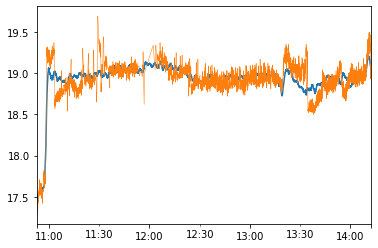

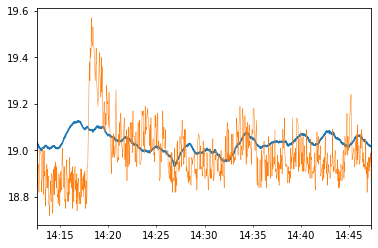

In [69]:
testcol = 'S1_Out_Meas9_PV'
test2=pd.DataFrame(yp[:,y_list.index(testcol)],index=train,columns=[f"{testcol}_pred"])
test2[testcol]=y_train[testcol]
fig=plt.figure()
test2[f"{testcol}_pred"].plot()
test2[testcol].plot(linewidth=0.5)

test3=pd.DataFrame(np.array(y[y_list.index(testcol)][len(init_ttss):]),columns=[f"{testcol}_pred"],index=y_valid.index)
#test3=pd.DataFrame(np.array(y[y_list.index(testcol)]),columns=[f"{testcol}_pred"],index=y_valid.index)
#test3=pd.DataFrame(np.array(yp[:,0]),columns=['S1_Out_Meas4_PV_pred'],index=y_train.index)
#test3=pd.DataFrame(np.array(y[0]),columns=['S1_Out_Meas5_PV_pred'],index=y_train.index)
test3[testcol]=y_valid[testcol]
#test3['S1_Out_Meas5_PV']=y_train['S1_Out_Meas5_PV']
#test3['S1_Out_Meas4_PV_pred']=test3['S1_Out_Meas4_PV_pred']+31.44
display(test3)
fig=plt.figure()
test3[f"{testcol}_pred"].plot()
test3[testcol].plot(linewidth=0.5)
ax=fig.gca()
#ax.set_ylim([5,5.7]);

In [30]:
# Function to calculate ARX model Mean-Square-Error (MSE)
def calc_mse(yp,y,y_train,y_valid,lgth=len(init_ttss)):
    y_pred=pd.DataFrame(np.array(y).T[lgth:],index=y_valid.index,columns=y_valid.columns)
    mse_train=mean_squared_error(yp,y_train.values)
    mse_valid=mean_squared_error(y_pred.values,y_valid.values)
    print(f"MSE for training data = {mse_train}")
    print(f"MSE for validation data = {mse_valid}")
    return mse_train,mse_valid

# Calculate baseline MSE's based on model structure from initial EDA
base_mse=calc_mse(yp,y,y_train,y_valid)

MSE for training data = 0.07337476850676007
MSE for validation data = 0.7276102989548601


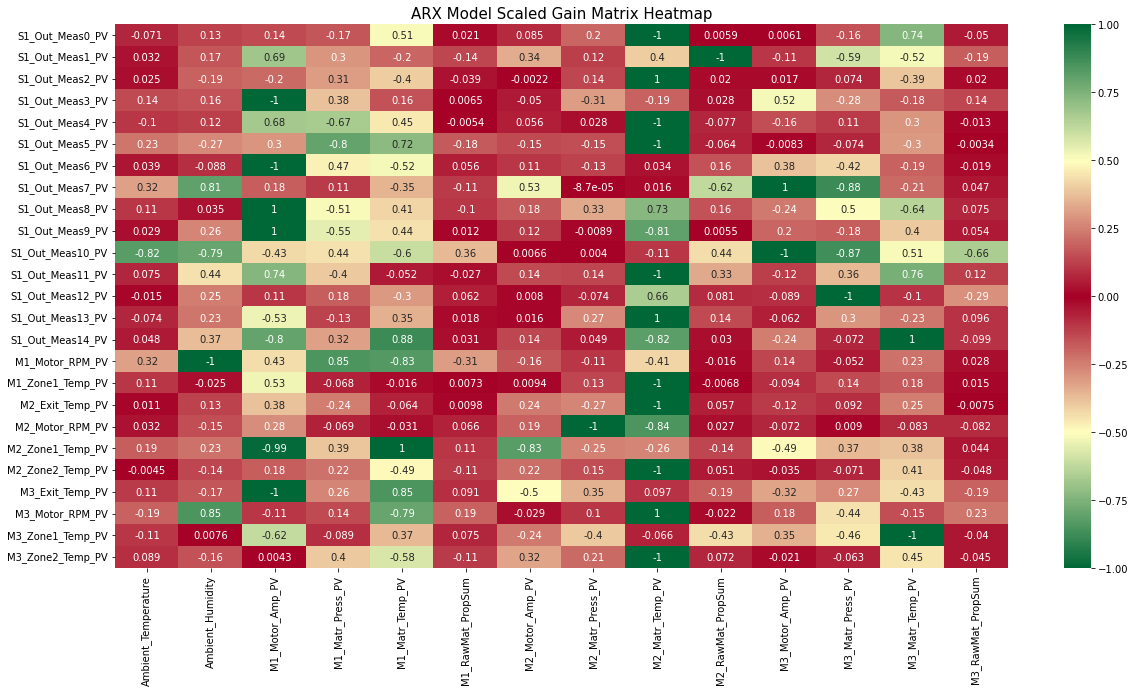

In [31]:
# Save gain matrix in a dataframe
GainMatrix=pd.DataFrame(K,index=y_list,columns=u_list)

# Create scaled gain matrix for gain heatmap.
# Idea for scaling here is to divide the gain array for each target (i.e. wrt all the inputs) by the maximum 
# absolute gain value amongst inputs to the target
GainMap = GainMatrix.copy(deep=True)
for i in GainMap.index:
    GainMap.loc[i]=GainMap.loc[i]/GainMap.loc[i].abs().max()

# Plot scaled gain matrix heatmap
plt.figure(figsize=(20,10))
g4 = sns.heatmap(GainMap,annot=True,cmap=cmap,vmin=-1.0,vmax=1.0)
g4.set_title('ARX Model Scaled Gain Matrix Heatmap',fontsize=15);

In [32]:
# Now look into PCA for the correlated RawMat inputs
# Define some functions

def calc_pca(mc_id):
    # Copy RawMat columns
    features = [f"M{mc_id}_RawMat_Prop{i}" for i in range(1,5)]
    X = df_nospke.copy(deep=True).loc[:,features]

    # Standardize
    X_scaled = (X - X.mean(axis=0))/X.std(axis=0)

    # Create principal components
    pca = PCA()
    X_pca =  pca.fit_transform(X_scaled)
    component_names = [f"M{mc_id}_RawMat_Prop_PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns = component_names,index=X_scaled.index)

    # Calculate PCA loadings
    loadings = pd.DataFrame(
                            pca.components_.T,
                            columns = component_names,
                            index = X.columns
    )
    return pca,X_pca,loadings,X_scaled

# Function to look at plot of explained variance
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [33]:
#_,X_pca1,_,_=calc_pca(1)
#_,X_pca2,_,_=calc_pca(2)
#_,X_pca3,_,_=calc_pca(3)
#df_nospke = pd.concat([despiked_df(),X_pca1,X_pca2,X_pca3],axis=1)


In [34]:
#u_list = u_list + [col for col in df_nospke.columns if 'PC' in col]

In [35]:
#u_list

**------------------Work Cells below here----------------------**

<Figure size 432x288 with 0 Axes>

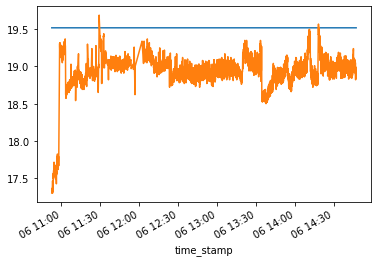

In [ ]:
plt.figure()
ax=plt.figure().gca()
df_nospke['S1_Out_Meas9_SP'].plot(ax=ax)
df_nospke['S1_Out_Meas9_PV'].plot(ax=ax)

In [ ]:
#df[['S1_Out_Meas0_SP','M3_Motor_Amp_PV']].loc['2019-03-06 11:53:33':'2019-03-06 12:00:33']
df.eq(0.0).sum(axis=0).sort_values(ascending=False)[:20]

S1_Out_Meas5_PV     13400
S2_Out_Meas4_PV     12754
S1_Out_Meas11_PV    10462
S1_Out_Meas7_PV      8761
S1_Out_Meas1_PV      5900
S1_Out_Meas14_PV     5005
S1_Out_Meas6_PV      4703
S2_Out_Meas9_PV      4198
S1_Out_Meas12_PV     3188
S2_Out_Meas0_PV      1224
S2_Out_Meas8_PV       973
S2_Out_Meas14_PV      912
S1_Out_Meas8_PV       777
S2_Out_Meas3_PV       772
S1_Out_Meas9_PV       722
S2_Out_Meas1_PV       676
S2_Out_Meas10_PV      635
S2_Out_Meas11_PV      628
S2_Out_Meas2_PV       604
S2_Out_Meas7_PV       346
dtype: int64

In [ ]:



#plt.figure()
#test=list(df[df['S1_Out_Meas5_PV'].le(1.5)|df['S1_Out_Meas5_PV'].ge(2.9)].loc[:,'S1_Out_Meas5_PV'].values)
#df['S1_Out_Meas5_PV']=df['S1_Out_Meas5_PV'].replace(to_replace=test,value=np.nan)
#df['S1_Out_Meas5_PV'].interpolate('pad').plot()

In [ ]:
# Define function for calculating lagged mutual information (MI) between any 2 variables
def lagged_mi_scores(X,y,max_lag):
  X=pd.DataFrame(X)
  #mi_lagd = [mutual_info_regression(X.shift(t).fillna(X.squeeze().values[0]),y)[0] for t in range(0,max_lag)]
  mi_lagd = [y.corr(X.shift(t).fillna(X.squeeze().values[0]).squeeze()) for t in range(0,max_lag)]
  #mi_lagd = pacf(X,max_lag)
  mi_lagd = pd.Series(mi_lagd,index=range(0,max_lag),name=X.columns[0])
  #mi_lagd = pd.Series(mi_lagd,index=range(0,max_lag+1),name=X.columns[0])
  fig=plt.figure()
  fig.set_size_inches([10,5])
  plt.bar(mi_lagd.index,mi_lagd,align='center',width=0.8)
  plt.xlabel('Lags')
  plt.title(f"{y.name} vs {X.columns[0]} lagged ({max_lag} lags)")
  plt.ylim(-1.0,1.1)
  return mi_lagd
#_=lagged_mi_scores(df_nospke['S1_CombnOp_Temp1_PV'],df_nospke['S1_Out_Meas4_PV'],40)
#np.argmax(np.abs(lagged_mi_scores(df_nospke['M1_Motor_RPM_PV'],df_nospke['S1_Out_Meas5_PV'],3600)))
#df_nospke['M1_Motor_RPM_PV'].corr(df_nospke['S1_Out_Meas5_PV'])

In [ ]:
noise=np.random.normal(0,0.1,len(df_nospke))
VarA=pd.DataFrame(range(0,len(df_nospke))+noise,index=df_nospke.index,columns=['Variable A'])
VarB=35*VarA.rename(columns={'Variable A':'Variable B'})
VarB=VarB.shift(120).fillna(VarB.squeeze().values[0])

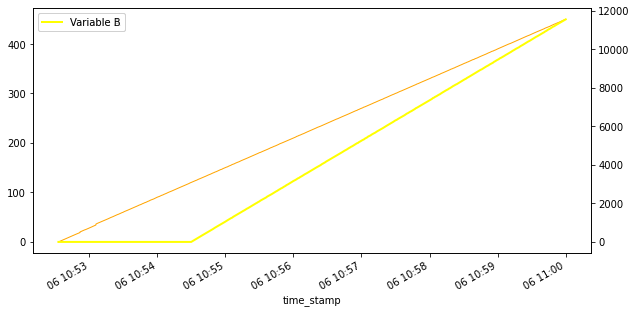

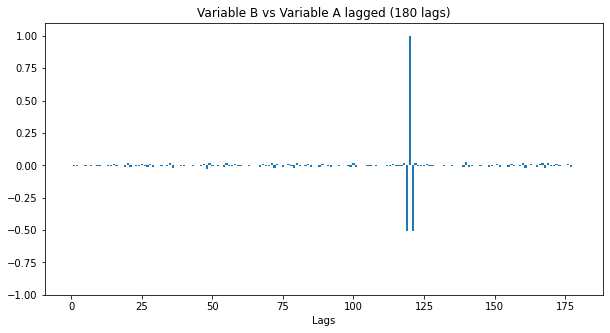

In [ ]:
fig=plt.figure(figsize=(10,5))
ax=fig.gca()
VarA.loc['2019-03-06 10:52:33':'2019-03-06 11:00:00'].plot(ax=ax,linewidth=1,color='orange')
ax2=ax.twinx()
VarB.loc['2019-03-06 10:52:33':'2019-03-06 11:00:00'].plot(ax=ax2,linewidth=2,color='yellow')
_=lagged_mi_scores(VarA.diff().squeeze(),VarB.diff().squeeze(),180)

In [ ]:
VarA.shift(0).fillna(VarA.squeeze().values[0]).squeeze().corr(VarB.squeeze())

0.99999878237157

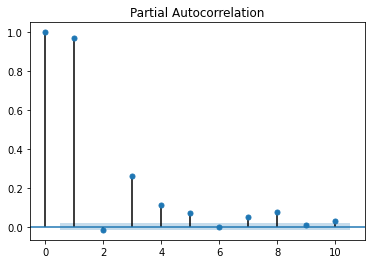

In [ ]:
plot_pacf(df_nospke['S1_Out_Meas0_PV'], lags = 10);

-0.58646035955228

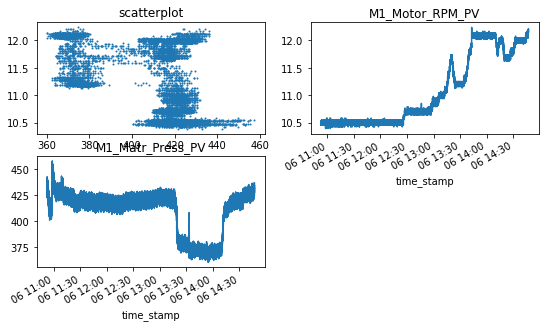

In [ ]:
y=df_nospke['M1_Motor_RPM_PV'].apply(lambda x:x)
X=df_nospke['M1_Matr_Press_PV'].apply(lambda x:x)
gspec=gridspec.GridSpec(2,2)
fig=plt.figure(figsize=[9,5])
plt.subplot(gspec[0,0])
plot1=plt.scatter(X,y,s=1)
plot1.figure.gca().set_title('scatterplot')
plt.subplot(gspec[0,1])
plot2=y.plot(title=f"{y.name}")
plt.subplot(gspec[1,0])
plot3=X.plot(title=f"{X.name}")
y.corr(X)

# Scatterplot Matrix
gspec=gridspec.GridSpec(len(feat_list),len(PV_S1_col_list))
fig=plt.figure()
fig.set_size_inches([600,480])
fig.suptitle('Target - Input Feature Scatterplots Matrix',fontsize=15)
fig.subplots_adjust(top=0.97,hspace=0.7,wspace=0.3)

for col in PV_S1_col_list:
  corr_list = []
  for idx in feat_list:
    corr_list.append(df_nospke[col].corr(df_nospke[idx], method="pearson"))
    j = PV_S1_col_list.index(col)
    i = list(feat_list).index(idx)
    thisplot=plt.subplot(gspec[i,j])
    thisplot.scatter(df_nospke[idx],df_nospke[col],s=1)
    thisplot.figure.set_size_inches([40,80])
    thisplot.set_title(f"{col} vs.\n {idx}",fontsize=8)
    thisplot.tick_params(axis='y', labelsize=8)
    thisplot.tick_params(axis='x', labelsize=8)
    #thisplot.set_xlabel('Lags',fontsize=11)
  df_corr = pd.concat([df_corr,pd.Series(corr_list,index=feat_list,name=col)],axis=1)  
#display(df_corr)

**-- Code below is based on a response to a question on stackoverflow - https://stackoverflow.com/questions/37556487/remove-spikes-from-signal-in-python --**

# Source: https://stackoverflow.com/questions/37556487/remove-spikes-from-signal-in-python

# import logging
import numpy as np
import pandas as pd

#logging.basicConfig(datefmt='%H:%M:%S',
#                    stream=sys.stdout, level=logging.DEBUG,
#                    format='%(asctime)s %(message)s')

# Distance away from the FBEWMA that data should be removed.
DELTA = 0.1

# clip data above this value:
HIGH_CLIP = 2.1

# clip data below this value:
LOW_CLIP = -2.1

# random values above this trigger a spike:
RAND_HIGH = 0.98

# random values below this trigger a negative spike:
RAND_LOW = 0.02

# How many samples to run the FBEWMA over.
SPAN = 10

# spike amplitude
SPIKE = 2


def clip_data(unclipped, high_clip, low_clip):
    ''' Clip unclipped between high_clip and low_clip. 
    unclipped contains a single column of unclipped data.'''
    
    # convert to np.array to access the np.where method
    np_unclipped = np.array(unclipped)
    # clip data above HIGH_CLIP or below LOW_CLIP
    cond_high_clip = (np_unclipped > HIGH_CLIP) | (np_unclipped < LOW_CLIP)
    np_clipped = np.where(cond_high_clip, np.nan, np_unclipped)
    return np_clipped.tolist()


def create_sample_data():
    ''' Create sine wave, amplitude +/-2 with random spikes. '''
    x = np.linspace(0, 2*np.pi, 1000)
    y = 2 * np.sin(x)
    df = pd.DataFrame(list(zip(x,y)), columns=['x', 'y'])
    df['rand'] = np.random.random_sample(len(x),)
    # create random positive and negative spikes
    cond_spike_high = (df['rand'] > RAND_HIGH)
    df['spike_high'] = np.where(cond_spike_high, SPIKE, 0)
    cond_spike_low = (df['rand'] < RAND_LOW)
    df['spike_low'] = np.where(cond_spike_low, -SPIKE, 0)
    df['y_spikey'] = df['y'] + df['spike_high'] + df['spike_low']
    return df


def ewma_fb(df_column, span):
    ''' Apply forwards, backwards exponential weighted moving average (EWMA) to df_column. '''
    # Forwards EWMA.
    fwd = pd.Series.ewm(df_column, span=span).mean()
    # Backwards EWMA.
    bwd = pd.Series.ewm(df_column[::-1],span=10).mean()
    # Add and take the mean of the forwards and backwards EWMA.
    stacked_ewma = np.vstack(( fwd, bwd[::-1] ))
    fb_ewma = np.mean(stacked_ewma, axis=0)
    return fb_ewma
    
    
def remove_outliers(spikey, fbewma, delta):
    ''' Remove data from df_spikey that is > delta from fbewma. '''
    np_spikey = np.array(spikey)
    np_fbewma = np.array(fbewma)
    cond_delta = (np.abs(np_spikey-np_fbewma) > delta)
    np_remove_outliers = np.where(cond_delta, np.nan, np_spikey)
    return np_remove_outliers

    
def main():
    df = create_sample_data()
    df['y_clipped'] = clip_data(df['y_spikey'].tolist(), HIGH_CLIP, LOW_CLIP)
    print(f"Data type is {type(df['y_clipped'])}")  # Added this line for troubleshooting
    df['y_ewma_fb'] = ewma_fb(df['y_clipped'], SPAN)
    df['y_remove_outliers'] = remove_outliers(df['y_clipped'].tolist(), df['y_ewma_fb'].tolist(), DELTA)
    df['y_interpolated'] = df['y_remove_outliers'].interpolate()
    
    ax = df.plot(x='x', y='y_spikey', color='blue', alpha=0.5)
    ax2 = df.plot(x='x', y='y_interpolated', color='black', ax=ax)
    
main()

#Snippet from stackoverflow for time-series sysid 
#(https://stackoverflow.com/questions/37695253/python-identifying-a-state-space-model-for-a-system)

# load data and parse into columns
url = 'http://apmonitor.com/do/uploads/Main/tclab_dyn_data2.txt'
data = pd.read_csv(url)
t = data['Time']
u = data[['H1','H2']]
y = data[['T1','T2']]

# generate time-series model
m = GEKKO(remote=False) # remote=True for MacOS

# system identification
na = 1 # output coefficients
nb = 2 # input coefficients
yp,p,K = m.sysid(t,u,y,na,nb,diaglevel=1)

plt.figure()
plt.subplot(2,1,1)
plt.plot(t,u)
plt.legend([r'$u_0$',r'$u_1$'])
plt.ylabel('MVs')
plt.subplot(2,1,2)
plt.plot(t,y)
plt.plot(t,yp)
plt.legend([r'$y_0$',r'$y_1$',r'$z_0$',r'$z_1$'])
plt.ylabel('CVs')
plt.xlabel('Time')
#plt.savefig('sysid.png')
plt.show()

# State-space controller.
# Code obtained from here: https://apmonitor.com/wiki/index.php/Apps/LinearStateSpace

A = np.array([[-.003, 0.039, 0, -0.322],
              [-0.065, -0.319, 7.74, 0],
              [0.020, -0.101, -0.429, 0],
              [0, 0, 1, 0]])

B = np.array([[0.01, 1, 2],
              [-0.18, -0.04, 2],
              [-1.16, 0.598, 2],
              [0, 0, 2]]
            )

C = np.array([[1, 0, 0, 0],
              [0, -1, 0, 7.74]])

#%% Build GEKKO State Space model
m = GEKKO()
x,y,u = m.state_space(A,B,C,D=None)

# customize names
# MVs
mv0 = u[0]
mv1 = u[1]
# Feedforward
ff0 = u[2]
# CVs
cv0 = y[0]
cv1 = y[1]

m.time = [0, 0.1, 0.2, 0.4, 1, 1.5, 2, 3, 4]
m.options.imode = 6
m.options.nodes = 3

u[0].lower = -100
u[0].upper = 100
u[0].dcost = 1
u[0].status = 1

u[1].lower = -100
u[1].upper = 100
u[1].dcost = 1
u[1].status = 1

## CV tuning
# tau = first order time constant for trajectories
y[0].tau = 5
y[1].tau = 8
# tr_init = 0 (dead-band)
#         = 1 (first order trajectory)
#         = 2 (first order traj, re-center with each cycle)
y[0].tr_init = 0
y[1].tr_init = 0
# targets (dead-band needs upper and lower values)
# SPHI = upper set point
# SPLO = lower set point
y[0].sphi= -8.5
y[0].splo= -9.5
y[1].sphi= 1.0
y[1].splo= 0.0

y[0].status = 1
y[1].status = 1

# feedforward
u[2].status = 0
u[2].value = np.zeros(np.size(m.time))
u[2].value[3:] = 2.5

m.solve() # (GUI=True)

# also create a Python plot
import matplotlib.pyplot as plt

plt.subplot(2,1,1)
plt.plot(m.time,mv0.value,'r-',label=r'$u_0$ as MV')
plt.plot(m.time,mv1.value,'b--',label=r'$u_1$ as MV')
plt.plot(m.time,ff0.value,'g:',label=r'$u_2$ as feedforward')
plt.legend()
plt.subplot(2,1,2)
plt.plot(m.time,cv0.value,'r-',label=r'$y_0$')
plt.plot(m.time,cv1.value,'b--',label=r'$y_1$')
plt.legend()
plt.show()

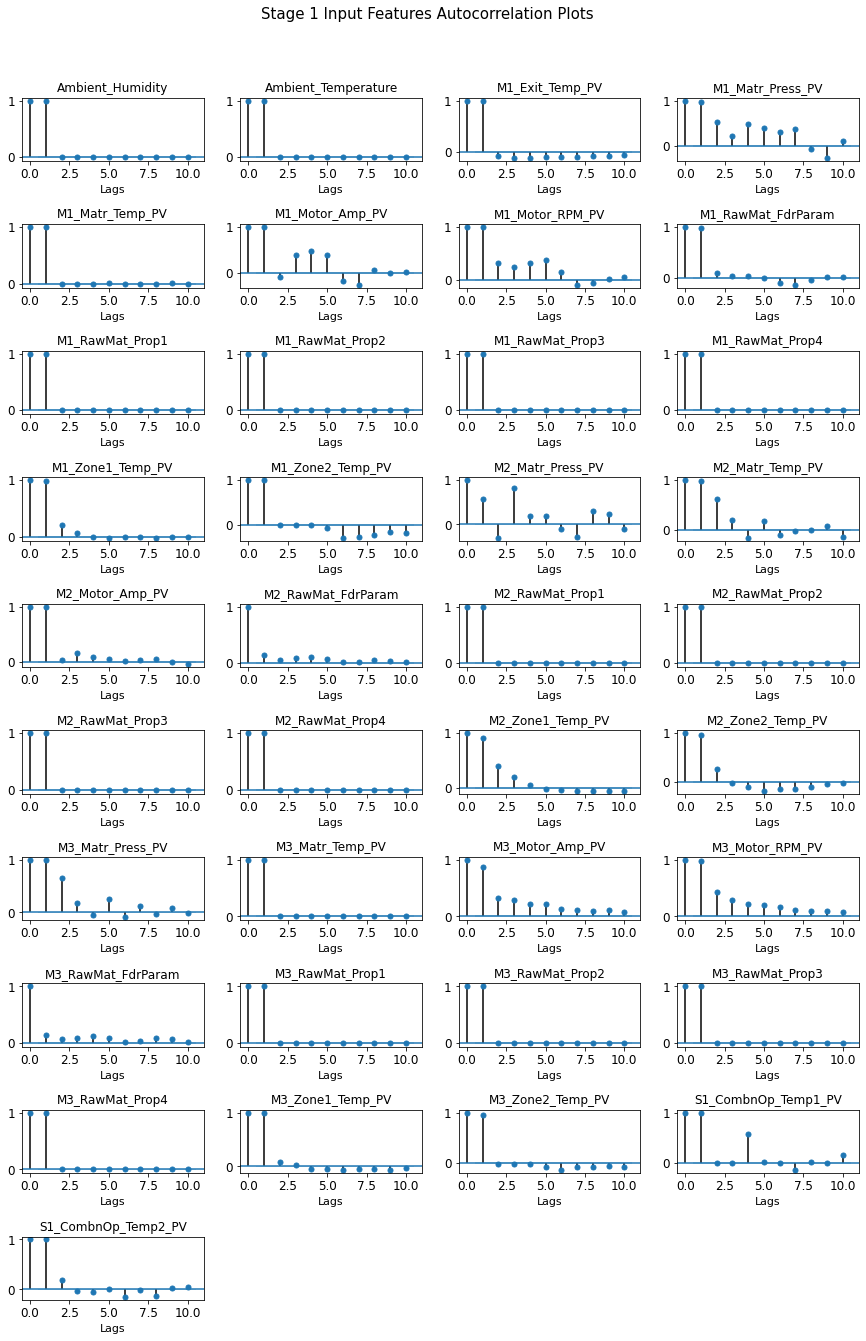

In [ ]:
# Plot PACF for Stage 1 Input Features
gspec=gridspec.GridSpec(10,4)
fig=plt.figure()
fig.set_size_inches([90,72])
fig.suptitle('Stage 1 Input Features Autocorrelation Plots',fontsize=15)
fig.subplots_adjust(top=0.92,hspace=1.0)
count=0
for i in range(0,10):
    for j in range(0,4):
        count+=1
        if count>37:
            break
        thisplot=plt.subplot(gspec[i,j])
        this_col=feat_list[count-1]
        plot_pacf(df_nospke[this_col],lags=10,ax=thisplot)
        thisplot.figure.set_size_inches([15,21])
        thisplot.set_title(f"{this_col}",fontsize=12)
        thisplot.tick_params(axis='y', labelsize=12)
        thisplot.tick_params(axis='x', labelsize=12)
        thisplot.set_xlabel('Lags',fontsize=11)

<Figure size 432x288 with 0 Axes>

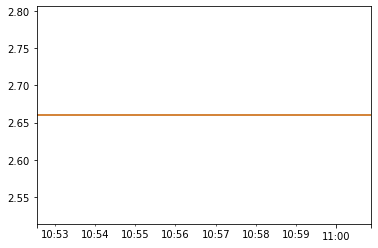

In [ ]:
test3=pd.DataFrame(yp,index=t_train,columns=y_list)
plt.figure()
ax = plt.figure().gca()
test3['S1_Out_Meas5_PV'].plot()
df_nospke['S1_Out_Meas5_PV'].loc[t_train].plot(ax=ax)


In [ ]:
K.shape

(19, 14)

In [ ]:
pd.DataFrame(K,index=y_list,columns=u_list)

Ambient_Temperature  Ambient_Humidity  M1_Motor_Amp_PV  \
S1_Out_Meas1_PV              1.266161         -1.446100        -0.023743   
S1_Out_Meas4_PV              0.802279         -0.192336         0.315836   
S1_Out_Meas5_PV              0.000000          0.000000         0.000000   
S1_Out_Meas6_PV             -0.127624          0.879603         0.345180   
S1_Out_Meas9_PV             -0.158864          0.075561        -0.475473   
S1_Out_Meas10_PV           -22.591186         16.096636       -35.364241   
S1_Out_Meas12_PV             0.886521         -0.968908        -0.022996   
M1_Exit_Temp_PV              0.334513         -0.299310        -0.209248   
M1_Motor_RPM_PV              0.110114         -0.074317        -0.019655   
M1_Zone1_Temp_PV             1.518044         -1.849937        -0.851686   
M1_Zone2_Temp_PV             0.592265          0.772973         0.772041   
M2_Exit_Temp_PV              0.531473         -0.156427         0.550803   
M2_Motor_RPM_PV              0.011312          0.016077         0.029066   
M2_Zone1_Temp_PV            -3.223964          4.256374         0.250016   
M2_Zone2_Temp_PV             4.378696         -4.845531         2.668301   
M3_Exit_Temp_PV              1.210294         -1.297480        -0.216193   
M3_Motor_RPM_PV             -0.051181          0.199972        -0.007805   
M3_Zone1_Temp_PV            -0.067789          0.180467         0.361074   
M3_Zone2_Temp_PV            -0.035753          0.272951         0.230587   

                  M1_Matr_Press_PV  M1_Matr_Temp_PV  M1_RawMat_PropSum  \
S1_Out_Meas1_PV           0.137349        -0.253526       3.098684e-15   
S1_Out_Meas4_PV           0.611782        -0.124643       9.378603e-15   
S1_Out_Meas5_PV           0.000000         0.000000       0.000000e+00   
S1_Out_Meas6_PV          -0.735891         5.556700      -5.145710e-14   
S1_Out_Meas9_PV           1.299781        -0.295491       2.554729e-14   
S1_Out_Meas10_PV         30.236331        53.427691       1.427805e-10   
S1_Out_Meas12_PV         -0.415386         1.534809       6.174397e-14   
M1_Exit_Temp_PV           0.036872        -0.065132      -1.628164e-15   
M1_Motor_RPM_PV           0.003012        -0.008565       9.708333e-17   
M1_Zone1_Temp_PV         -0.415871         6.346386       8.619383e-15   
M1_Zone2_Temp_PV         -0.423821         7.966818      -1.190509e-13   
M2_Exit_Temp_PV          -0.811615         0.265418      -4.311243e-14   
M2_Motor_RPM_PV          -0.013689        -0.009678       4.303159e-17   
M2_Zone1_Temp_PV          2.099336        -5.030754      -1.871654e-14   
M2_Zone2_Temp_PV         -5.015715        13.917808       6.160639e-15   
M3_Exit_Temp_PV           0.003184        -0.897863       1.443426e-13   
M3_Motor_RPM_PV           0.027496         0.274495      -4.638091e-16   
M3_Zone1_Temp_PV         -0.843245         1.792616      -3.470826e-14   
M3_Zone2_Temp_PV         -0.261719         0.877566      -5.152318e-17   

                  M2_Motor_Amp_PV  M2_Matr_Press_PV  M2_Matr_Temp_PV  \
S1_Out_Meas1_PV          0.053195         -0.392247         1.025820   
S1_Out_Meas4_PV          0.164589         -3.801028        -1.836743   
S1_Out_Meas5_PV          0.000000          0.000000         0.000000   
S1_Out_Meas6_PV          0.193798         -2.830047        -7.724351   
S1_Out_Meas9_PV         -0.234390         -1.404114        -2.583670   
S1_Out_Meas10_PV       -18.954826        -76.638150      -265.104159   
S1_Out_Meas12_PV        -0.338916          0.829411        -3.452527   
M1_Exit_Temp_PV          0.137408         -0.477846         0.163075   
M1_Motor_RPM_PV         -0.005489          0.002235         0.003866   
M1_Zone1_Temp_PV        -1.072095          3.015851       -18.952310   
M1_Zone2_Temp_PV         0.201676         -6.561922       -14.821569   
M2_Exit_Temp_PV          0.238112          0.054056        -1.067521   
M2_Motor_RPM_PV         -0.003439         -0.007547         0.002383   
M2_Zone1

na = 2 # Number of A coefficients
nb = 1 # Number of B coefficients
ny = 2 # Number of outputs
nu = 2 # Number of inputs

# A (na x ny)
A = np.array([[0.36788,0.36788],\
              [0.223,-0.136]])
# B (ny x (nb x nu))
B1 = np.array([0.63212,0.18964]).T
B2 = np.array([0.31606,1.26420]).T
B = np.array([[B1],[B2]])

C = np.array([0,0])

# create parameter dictionary
# parameter dictionary p['a'], p['b'], p['c']
# a (coefficients for a polynomial, na x ny)
# b (coefficients for b polynomial, ny x (nb x nu))
# c (coefficients for output bias, ny)
p = {'a':A,'b':B,'c':C}

# Create GEKKO model
m = GEKKO(remote=False)

# Build GEKKO ARX model
y,u = m.arx(p)

# load inputs
tf = 20 # final time
u1 = np.zeros(tf+1)
u2 = u1.copy()
u1[5:] = 3.0
u2[10:] = 5.0
u[0].value = u1
u[1].value = u2

# customize names
mv1 = u[0]
mv2 = u[1]
cv1 = y[0]
cv2 = y[1]

# options
m.time = np.linspace(0,tf,tf+1)
m.options.imode = 4
m.options.nodes = 2

# simulate
m.solve()

plt.figure(1)
plt.subplot(2,1,1)
plt.plot(m.time,mv1.value,'r-',label=r'$MV_1$')
plt.plot(m.time,mv2.value,'b--',label=r'$MV_2$')
plt.ylabel('MV')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(m.time,cv1.value,'r:',label=r'$CV_1$')
plt.plot(m.time,cv2.value,'b.-',label=r'$CV_2$')
plt.ylabel('CV')
plt.xlabel('Time (sec)')
plt.legend(loc='best')
plt.show()

In [ ]:
test3=pd.DataFrame(np.array(y[0]),columns=['Step Response'],index=y_train.index)
#test3['S1_Out_Meas4_PV']=y_valid['S1_Out_Meas4_PV']
test3['Step Input']= np.array(u[0])
#test3['S1_Out_Meas4_PV_pred']=test3['S1_Out_Meas4_PV_pred']+31.44
fig=plt.figure()
ax=fig.gca()
test3['Step Response'].plot(ax=ax,color='orange')
ax2=ax.twinx()
test3['Step Input'].plot(ax=ax2)
test3

[0, 0]

In [ ]:
#np.save(path+'K1000.npy',K)
#np.save(path+'pa1000.npy',p['a'])
#np.save(path+'pb1000.npy',p['b'])
#np.save(path+'pc1000.npy',p['c'])
#np.save(path+'yp1000.npy',yp)

In [ ]:
#K=np.load(path+'K1000.npy')
#p={}
#p['a']=np.load(path+'pa1000.npy')
#p['b']=np.load(path+'pb1000.npy')
#p['c']=np.load(path+'pc1000.npy')